In [2]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
from datetime import datetime
import numpy as np
import json
import math as m
from matplotlib import pyplot as plt
import statistics as s
from selenium import webdriver
from functools import reduce
import time
from statistics import median as med
from IPython.display import clear_output
from collections import Counter
import seaborn as sns
from os import path

#Learning
import torch
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import log_loss,confusion_matrix
import plotly.express as px  
import sklearn
import copy
import torch.optim as optim

# Downloading data from the website

In [2]:
#link to iaaf website with all results under 10.55s from 6/04/1896 to 4/11/2022
url = 'https://www.worldathletics.org/records/all-time-toplists/sprints/100-metres/outdoor/men/senior?regionType=world&timing=electronic&windReading=regular&page=1&bestResultsOnly=true&firstDay=1896-04-06&lastDay=2022-11-04'

In [3]:
req = requests.get(url).content
soup = BeautifulSoup(req)

In [4]:
#number of pages with results
how_page = int(str(soup.find('div', class_ = 'container--pagination__inner').find_all('form')[0]).split('max="')[1].split('"')[0])

In [5]:
#creating a dictionary country abbreviation - country name
for i in range(len(soup.find_all('script'))):
    if 'requirejs' in str(soup.find_all('script')[i])[0:30]:
        dict_country = soup.find_all('script')[i]
dict_country = str(dict_country).split('toplists.init(')[1][25:].split(',\n')[0]
list_country = json.loads(dict_country)
list_country = list_country[5]['cases'][2]['values']
list_country

[{'value': 'afg', 'label': 'Afghanistan'},
 {'value': 'alb', 'label': 'Albania'},
 {'value': 'alg', 'label': 'Algeria'},
 {'value': 'asa', 'label': 'American Samoa'},
 {'value': 'and', 'label': 'Andorra'},
 {'value': 'ang', 'label': 'Angola'},
 {'value': 'aia', 'label': 'Anguilla'},
 {'value': 'ant', 'label': 'Antigua & Barbuda'},
 {'value': 'arg', 'label': 'Argentina'},
 {'value': 'arm', 'label': 'Armenia'},
 {'value': 'aru', 'label': 'Aruba'},
 {'value': 'aus', 'label': 'Australia'},
 {'value': 'aut', 'label': 'Austria'},
 {'value': 'aze', 'label': 'Azerbaijan'},
 {'value': 'bah', 'label': 'Bahamas'},
 {'value': 'brn', 'label': 'Bahrain'},
 {'value': 'ban', 'label': 'Bangladesh'},
 {'value': 'bar', 'label': 'Barbados'},
 {'value': 'blr', 'label': 'Belarus'},
 {'value': 'bel', 'label': 'Belgium'},
 {'value': 'biz', 'label': 'Belize'},
 {'value': 'ben', 'label': 'Benin'},
 {'value': 'ber', 'label': 'Bermuda'},
 {'value': 'bhu', 'label': 'Bhutan'},
 {'value': 'bol', 'label': 'Bolivia'},

In [223]:
#replacing the list with a dictionary in the form of abbreviation - name
#some countries no exist and abbreviations had to be added manually
dict_country_new = {}
for i in range(len(list_country)):
    dict_country_new[list_country[i]['value']] = list_country[i]['label']

dict_country_new['ana'] = 'Authorised Neutral Athlete'
dict_country_new['gdr'] = 'Nrd'
dict_country_new['urs'] = 'Zsrr'
dict_country_new['frg'] = 'Rfn'
dict_country_new['aho'] = 'Netherlands Antilles'
dict_country_new['tch'] = 'Czechoslovakia'
dict_country_new['art'] = 'Athlete Refugee Team'
dict_country_new['yug'] = 'Yugoslavia'
dict_country_new['scg'] = 'Serbia and Montenegro'
dict_country_new

{'afg': 'Afghanistan',
 'alb': 'Albania',
 'alg': 'Algeria',
 'asa': 'American Samoa',
 'and': 'Andorra',
 'ang': 'Angola',
 'aia': 'Anguilla',
 'ant': 'Antigua & Barbuda',
 'arg': 'Argentina',
 'arm': 'Armenia',
 'aru': 'Aruba',
 'aus': 'Australia',
 'aut': 'Austria',
 'aze': 'Azerbaijan',
 'bah': 'Bahamas',
 'brn': 'Bahrain',
 'ban': 'Bangladesh',
 'bar': 'Barbados',
 'blr': 'Belarus',
 'bel': 'Belgium',
 'biz': 'Belize',
 'ben': 'Benin',
 'ber': 'Bermuda',
 'bhu': 'Bhutan',
 'bol': 'Bolivia',
 'bih': 'Bosnia-Herzegovina',
 'bot': 'Botswana',
 'bra': 'Brazil',
 'ivb': 'British Virgin Islands',
 'bru': 'Brunei',
 'bul': 'Bulgaria',
 'bur': 'Burkina Faso',
 'bdi': 'Burundi',
 'cpv': 'Cabo Verde',
 'cam': 'Cambodia',
 'cmr': 'Cameroon',
 'can': 'Canada',
 'cay': 'Cayman Islands',
 'caf': 'Central African Republic',
 'cha': 'Chad',
 'chi': 'Chile',
 'tpe': 'Chinese Taipei',
 'col': 'Colombia',
 'dma': 'Commonwealth of Dominica',
 'com': 'Comoros',
 'cgo': 'Congo',
 'cok': 'Cook Islands',

In [8]:
#downloading page sources for all subpages
soup_str = []
for i in range(how_page):
    url_str = 'https://www.worldathletics.org/records/all-time-toplists/sprints/100-metres/outdoor/men/senior?regionType=world&timing=electronic&windReading=regular&page=' + str(i+1) + '&bestResultsOnly=true&firstDay=1896-04-06&lastDay=2022-11-04'
    req_str = requests.get(url_str).content
    soup_str.append(BeautifulSoup(req_str))

In [48]:
#creating a dictionary with the name, country of birth, country abbreviation, player number, date of birth, 
    #link to the player's website
athelete = []
abb_coun = []
country = []
number = []
date = []
url_athelete = []
athelete_data = {}

for k in range(len(soup_str)):
    how_athlete = soup_str[k].find('table', class_ = 'records-table').find_all('tr')
    for i in range(1, len(how_athlete)):
        url_ath = 'https://www.worldathletics.org/athletes/'
        ath = how_athlete[i].find_all('a')[0].text.replace('  ', '').replace('\n','')
        athelete.append(ath)

        how_data = how_athlete[i].find_all('td')
        for j in range(len(how_data)):
            if str(how_data[j]).split('"')[1] == 'Nat':
                abb = how_data[j].text.replace(' ', '').replace('\n','').lower()
                abb_coun.append(abb)
                coun = dict_country_new[abb]
                country.append(coun)

            if str(how_data[j]).split('"')[1] == 'Competitor':
                num = str(how_data[j].find_all('a')[0]).split('"')[1].split('-')[-1].split('=')[-1] 
                number.append(num)                 # sometimes there is - before the number, and sometimes =

            if str(how_data[j]).split('"')[1] == 'DOB':
                if how_data[j].text == '\n':      #sometimes there is no date of birth
                    birth_date = np.nan
                else:
                    birth_date = how_data[j].text.replace('  ', '').replace('\n', '') 
                date.append(birth_date)
        url_a = url_ath + country[k*100+i-1].replace(' ', '') + '/' + number[k*100+i-1]
        url_athelete.append(url_a)
        athelete_data[k*100+i-1] = {'name': ath, 'country': coun, 'abb_coun': abb, 'number': num, 'birth_date': birth_date, 'url_athlete': url_a}

In [49]:
athelete_data

{0: {'name': 'Usain BOLT',
  'country': 'Jamaica',
  'abb_coun': 'jam',
  'number': '14201847',
  'birth_date': '21 AUG 1986',
  'url_athlete': 'https://www.worldathletics.org/athletes/Jamaica/14201847'},
 1: {'name': 'Tyson GAY',
  'country': 'United States',
  'abb_coun': 'usa',
  'number': '14238588',
  'birth_date': '09 AUG 1982',
  'url_athlete': 'https://www.worldathletics.org/athletes/UnitedStates/14238588'},
 2: {'name': 'Yohan BLAKE',
  'country': 'Jamaica',
  'abb_coun': 'jam',
  'number': '14201842',
  'birth_date': '26 DEC 1989',
  'url_athlete': 'https://www.worldathletics.org/athletes/Jamaica/14201842'},
 3: {'name': 'Asafa POWELL',
  'country': 'Jamaica',
  'abb_coun': 'jam',
  'number': '14202176',
  'birth_date': '23 NOV 1982',
  'url_athlete': 'https://www.worldathletics.org/athletes/Jamaica/14202176'},
 4: {'name': 'Justin GATLIN',
  'country': 'United States',
  'abb_coun': 'usa',
  'number': '14238562',
  'birth_date': '10 FEB 1982',
  'url_athlete': 'https://www.w

In [93]:
df = pd.DataFrame(data = athelete_data).transpose()
df

,name,country,abb_coun,number,birth_date,url_athlete
0,Usain BOLT,Jamaica,jam,14201847,21 AUG 1986,https://www.worldathletics.org/athletes/Jamaic...
1,Tyson GAY,United States,usa,14238588,09 AUG 1982,https://www.worldathletics.org/athletes/United...
2,Yohan BLAKE,Jamaica,jam,14201842,26 DEC 1989,https://www.worldathletics.org/athletes/Jamaic...
3,Asafa POWELL,Jamaica,jam,14202176,23 NOV 1982,https://www.worldathletics.org/athletes/Jamaic...
4,Justin GATLIN,United States,usa,14238562,10 FEB 1982,https://www.worldathletics.org/athletes/United...
...,...,...,...,...,...,...
9194,D. SUDHAKAR,India,ind,15022828,NaN,https://www.worldathletics.org/athletes/India/...
9195,Ahmed Hossam EL DIN ALI ABU ZAID,Egypt,egy,14956182,29 JUL 2002,https://www.worldathletics.org/athletes/Egypt/...
9196,Akito SUZUKI,Japan,jpn,14951335,07 AUG 2003,https://www.worldathletics.org/athletes/Japan/...
9197,Toshiaki ATOMI,Japan,jpn,014963765,12 JAN 1997,https://www.worldathletics.org/athletes/Japan/...


In [97]:
#a function that changes the date in the form of a string to a date in the date type
def change_date(date_list):    #argument - list with dates, format: 18 NOV 1992
    day = []
    month = []
    year = []
    date = []
    months = {'JAN': 1, 'FEB': 2, 'MAR': 3, 'APR': 4, 'MAY': 5, 'JUN': 6, 'JUL': 7, 'AUG': 8, 'SEP':9, 'OCT': 10, 'NOV': 11, 'DEC': 12}
    
    for i in range(len(date_list)):
        if type(date_list[i]) == float and m.isnan(date_list[i]):    #if date is NaN
            date.append(np.nan)
            day.append(np.nan)
            month.append(np.nan)
            year.append(np.nan)

        else:
            if date_list[i].count(' ') == 2:                        #when correct date (day, month and year)
                day.append(date_list[i].split(' ')[0])
                month.append(months[date_list[i].split(' ')[1]])
                year.append(date_list[i].split(' ')[2])

            elif date_list[i].count(' ') == 1 and date_list[i][:-5] in months.keys() and date_list[i][-4:].isnumeric():
                day.append('1')                                      #only month and year
                month.append(months[date_list[i][:-5]])
                year.append(date_list[i][-4:])

            elif date_list[i].count(' ') == 0 and len(date_list[i]) == 4:
                day.append('1')                                     #only year
                month.append('1')
                year.append(date_list[i])

            elif len(date_list[i]) == 0:                            #no date
                day.append(np.nan)
                month.append(np.nan)
                year.append(np.nan)

            else:
                print(i, date_list[i])                               #unsupported cases

            if year[i] == np.nan:
                date.append(np.nan)

            else:
                d = day[i] + '-' + str(month[i]) + '-' + year[i]
                dd = datetime.strptime(d, '%d-%m-%Y').date()
                date.append(dd)
        
    return(date)

In [98]:
df['birth_date'] = change_date(df['birth_date'])
df

,name,country,abb_coun,number,birth_date,url_athlete
0,Usain BOLT,Jamaica,jam,14201847,1986-08-21,https://www.worldathletics.org/athletes/Jamaic...
1,Tyson GAY,United States,usa,14238588,1982-08-09,https://www.worldathletics.org/athletes/United...
2,Yohan BLAKE,Jamaica,jam,14201842,1989-12-26,https://www.worldathletics.org/athletes/Jamaic...
3,Asafa POWELL,Jamaica,jam,14202176,1982-11-23,https://www.worldathletics.org/athletes/Jamaic...
4,Justin GATLIN,United States,usa,14238562,1982-02-10,https://www.worldathletics.org/athletes/United...
...,...,...,...,...,...,...
9194,D. SUDHAKAR,India,ind,15022828,NaN,https://www.worldathletics.org/athletes/India/...
9195,Ahmed Hossam EL DIN ALI ABU ZAID,Egypt,egy,14956182,2002-07-29,https://www.worldathletics.org/athletes/Egypt/...
9196,Akito SUZUKI,Japan,jpn,14951335,2003-08-07,https://www.worldathletics.org/athletes/Japan/...
9197,Toshiaki ATOMI,Japan,jpn,014963765,1997-01-12,https://www.worldathletics.org/athletes/Japan/...


In [99]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9199 entries, 0 to 9198
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   name         9199 non-null   object
 1   country      9199 non-null   object
 2   abb_coun     9199 non-null   object
 3   number       9199 non-null   object
 4   birth_date   7956 non-null   object
 5   url_athlete  9199 non-null   object
dtypes: object(6)
memory usage: 761.1+ KB


In [100]:
#save file
df.to_csv(r'Data\df_iaaf_top_en.csv')

# Adding new athletes

In [101]:
#from another iaaf website you can download atheletes for a given year who have scores worse than 10.55
#until 2008 there are only scores below 10.55, so we download players from 2009

year_list =list(range(2009, 2022+1))
year_list

[2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2020,
 2021,
 2022]

In [102]:
#for 1 year - 1 url
url_year = []
for i in range(len(year_list)):
    url_year.append('https://www.worldathletics.org/records/toplists/sprints/100-metres/outdoor/men/senior/' + str(year_list[i]) + '?regionType=world&timing=electronic&windReading=regular&page=1&bestResultsOnly=true')

In [104]:
#downloading page sources for website with results per year
soup_year = []
for i in range(len(url_year)):
    req = requests.get(url_year[i]).content
    soup_year.append(BeautifulSoup(req))

In [132]:
#number of pages for each year
how_page_year = []
for i in range(len(soup_year)):
#for i in range(4):
    if i != 5 and i != 10:
        how_page_year.append(int(str(soup_year[i].find('div', class_ = 'container--pagination__inner').find_all('form')[0]).split('max="')[1].split('"')[0]))

how_page_year   #every year more and more, only in 2020 less, due to the pandemic

[27, 39, 42, 48, 49, 50, 50, 54, 58, 35, 69, 80]

In [133]:
#all urls for 2009 - 2022
url = {}
for i in range(len(how_page_year)):
    list_url = []
    for j in range(how_page_year[i]):
        list_url.append('https://www.worldathletics.org/records/toplists/sprints/100-metres/outdoor/men/senior/' + str(year_list[i]) + '?regionType=world&timing=electronic&windReading=regular&page=' + str(j+1) + '&bestResultsOnly=true')
    url[year_list[i]] = list_url
url

{2009: ['https://www.worldathletics.org/records/toplists/sprints/100-metres/outdoor/men/senior/2009?regionType=world&timing=electronic&windReading=regular&page=1&bestResultsOnly=true',
  'https://www.worldathletics.org/records/toplists/sprints/100-metres/outdoor/men/senior/2009?regionType=world&timing=electronic&windReading=regular&page=2&bestResultsOnly=true',
  'https://www.worldathletics.org/records/toplists/sprints/100-metres/outdoor/men/senior/2009?regionType=world&timing=electronic&windReading=regular&page=3&bestResultsOnly=true',
  'https://www.worldathletics.org/records/toplists/sprints/100-metres/outdoor/men/senior/2009?regionType=world&timing=electronic&windReading=regular&page=4&bestResultsOnly=true',
  'https://www.worldathletics.org/records/toplists/sprints/100-metres/outdoor/men/senior/2009?regionType=world&timing=electronic&windReading=regular&page=5&bestResultsOnly=true',
  'https://www.worldathletics.org/records/toplists/sprints/100-metres/outdoor/men/senior/2009?regio

In [140]:
#downloading page sources for each website with results per year 2009 - 2022
soup = {}
for j in (year_list):
    list_soup = []
    for i in range(len(url[j])):
        req = requests.get(url[j][i]).content
        list_soup.append(BeautifulSoup(req))
    soup[j] = list_soup

KeyError: 2021

In [141]:
#only pages with results worse than 10.55
page_limit = {}
for j in range(len(soup)):
    for i in range(len(soup[year_list[j]])):
        mark = float(soup[year_list[j]][i].find('table', class_ = 'records-table').find_all('tr')[1].find_all('td')[1].text.replace(' ', '').replace('\n',''))
        if mark > 10.55:
            page_limit[year_list[j]] = i-1
            break

AttributeError: 'NoneType' object has no attribute 'find_all'

In [142]:
dicto = {}
for k in range(len(year_list)):
    for i in range(page_limit[year_list[k]], len(soup[year_list[k]])):
        ath = soup[year_list[k]][i].find('table', class_ = 'records-table').find_all('tr')
        for j in range(1, len(ath)): 
            if ath[j].find('a') is not None:   #some players are not numbered
                number = (int(str(ath[j].find('a')).replace('-', '=').split('">')[0].split('=')[-1]))
                if number not in df['number'].tolist():   #check if this player is already in df
                    new_number = number
                    name = (ath[j].find('a').text.replace('  ', '').replace('\n', ''))
                    abb_coun = str(ath[j].find('img', class_ = 'tableflag')).split('alt="')[1][:3]
                    date = ath[j].find_all('td')[4].text.replace('  ', '').replace('\n', '')
                    dicto = {'name': name, 'abb_coun': abb_coun, 'number': number, 'birth_date': date}
                    df = df.append(dicto, ignore_index=True)    #add to df

KeyError: 2009

In [219]:
date = change_date(df['birth_date'][9200:].to_list())
df['birth_date'][9200:] = date

0 1997-09-24


IndexError: list index out of range

In [415]:
#change type of date from str to datetime
df['birth_date'].replace('None', pd.NaT, inplace=True)

dd = []
for d in df['birth_date']:
    dd.append(pd.to_datetime(d))
df['birth_date'] = dd
df

,name,country,abb_coun,number,birth_date,url_athlete
0,Usain BOLT,Jamaica,jam,14201847,1986-08-21,https://www.worldathletics.org/athletes/Jamaic...
1,Tyson GAY,United States,usa,14238588,1982-08-09,https://www.worldathletics.org/athletes/United...
2,Yohan BLAKE,Jamaica,jam,14201842,1989-12-26,https://www.worldathletics.org/athletes/Jamaic...
3,Asafa POWELL,Jamaica,jam,14202176,1982-11-23,https://www.worldathletics.org/athletes/Jamaic...
4,Justin GATLIN,United States,usa,14238562,1982-02-10,https://www.worldathletics.org/athletes/United...
...,...,...,...,...,...,...
33801,Rikuto MIZUTA,NaN,JPN,14957186,2003-04-07,NaN
33802,Yuta KOMAMURA,NaN,JPN,14921546,2003-10-21,NaN
33803,Yuki NAKANO,NaN,JPN,15051808,2006-05-03,NaN
33804,Ravi RAI,NaN,IND,14873399,2004-08-07,NaN


In [416]:
#change upper case to lower in abb_coun column
df['abb_coun'] = df['abb_coun'].str.lower()

In [417]:
#function that uses a dictionary to change country abbreviations to a long country name
def change_country(abb_list):
    country_list = []
    for i in range(len(abb_list)):
        country_list.append(dict_country_new[abb_list[i]])
    return(country_list)

In [418]:
df['country'] = change_country(df['abb_coun'])
df

,name,country,abb_coun,number,birth_date,url_athlete
0,Usain BOLT,Jamaica,jam,14201847,1986-08-21,https://www.worldathletics.org/athletes/Jamaic...
1,Tyson GAY,United States,usa,14238588,1982-08-09,https://www.worldathletics.org/athletes/United...
2,Yohan BLAKE,Jamaica,jam,14201842,1989-12-26,https://www.worldathletics.org/athletes/Jamaic...
3,Asafa POWELL,Jamaica,jam,14202176,1982-11-23,https://www.worldathletics.org/athletes/Jamaic...
4,Justin GATLIN,United States,usa,14238562,1982-02-10,https://www.worldathletics.org/athletes/United...
...,...,...,...,...,...,...
33801,Rikuto MIZUTA,Japan,jpn,14957186,2003-04-07,NaN
33802,Yuta KOMAMURA,Japan,jpn,14921546,2003-10-21,NaN
33803,Yuki NAKANO,Japan,jpn,15051808,2006-05-03,NaN
33804,Ravi RAI,India,ind,14873399,2004-08-07,NaN


In [419]:
#creating url per athlete with name, country and number
def create_url(country_list, number_list):
    url_list = []
    url_new = 'https://www.worldathletics.org/athletes/'
    
    for i in range(len(country_list)):
        url_new = 'https://www.worldathletics.org/athletes/'
        url_new = url_new + country_list[i] + '/' + str(number_list[i])
        url_list.append(url_new)
    return(url_list)

In [420]:
df['url_athlete'][9200:] = create_url(df['country'][9200:].to_list(), df['number'][9200:].to_list())
df

C:\Users\adasz\AppData\Local\Temp\ipykernel_10804\1463559895.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['url_athlete'][9200:] = create_url(df['country'][9200:].to_list(), df['number'][9200:].to_list())


,name,country,abb_coun,number,birth_date,url_athlete
0,Usain BOLT,Jamaica,jam,14201847,1986-08-21,https://www.worldathletics.org/athletes/Jamaic...
1,Tyson GAY,United States,usa,14238588,1982-08-09,https://www.worldathletics.org/athletes/United...
2,Yohan BLAKE,Jamaica,jam,14201842,1989-12-26,https://www.worldathletics.org/athletes/Jamaic...
3,Asafa POWELL,Jamaica,jam,14202176,1982-11-23,https://www.worldathletics.org/athletes/Jamaic...
4,Justin GATLIN,United States,usa,14238562,1982-02-10,https://www.worldathletics.org/athletes/United...
...,...,...,...,...,...,...
33801,Rikuto MIZUTA,Japan,jpn,14957186,2003-04-07,https://www.worldathletics.org/athletes/Japan/...
33802,Yuta KOMAMURA,Japan,jpn,14921546,2003-10-21,https://www.worldathletics.org/athletes/Japan/...
33803,Yuki NAKANO,Japan,jpn,15051808,2006-05-03,https://www.worldathletics.org/athletes/Japan/...
33804,Ravi RAI,India,ind,14873399,2004-08-07,https://www.worldathletics.org/athletes/India/...


# Athlete analysis

In [421]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33806 entries, 0 to 33805
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   name         33806 non-null  object        
 1   country      33806 non-null  object        
 2   abb_coun     33806 non-null  object        
 3   number       33806 non-null  int64         
 4   birth_date   23149 non-null  datetime64[ns]
 5   url_athlete  33806 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 1.5+ MB


### Birth date

In [423]:
min(df['birth_date'])

Timestamp('1932-02-08 00:00:00')

In [424]:
max(df['birth_date'])

Timestamp('2008-02-15 00:00:00')

In [532]:
#list comprehension - decades from date
year = [x.year for x in df['birth_date']]
dozen = [int(repr(x)[-2]) if type(x) == int else np.nan for x in year]
dozen2 = [x + 10 if x < 3 else x for x in dozen]

In [533]:
#most athletes were born in the 1990s
pd.Series(dozen2).value_counts()

9.0     10287
10.0     5997
8.0      3926
7.0      1469
6.0       919
5.0       431
4.0       104
3.0        16
dtype: int64

Text(0.5, 1.0, 'Number of atheletes born in decades')

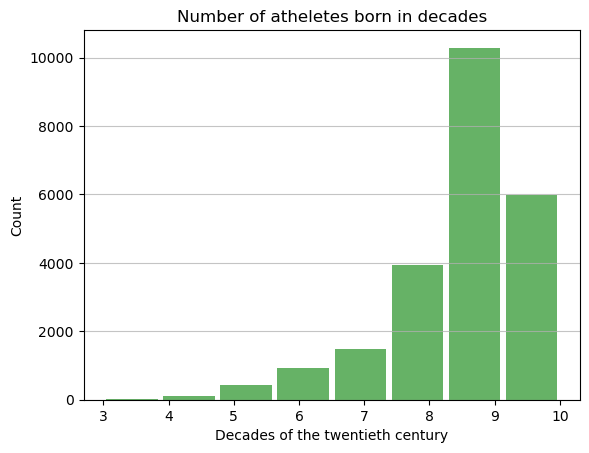

In [536]:
plt.hist(dozen2, bins = 8, alpha = 0.6, rwidth=0.9, color = 'green')
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Decades of the twentieth century')
plt.ylabel('Count') 
plt.title('Number of atheletes born in decades')

### Country

In [561]:
df_country = df[['country', 'name']].groupby(by = 'country', as_index = False).count()
df_country = df_country.rename(columns = {'name': 'count'})
df_country = df_country.sort_values('count', ascending = False).reset_index().drop(columns = 'index')
df_country

,country,count
0,United States,13254
1,Japan,3290
2,Great Britain & N.I.,1103
3,France,962
4,Jamaica,902
...,...,...
199,Palestine,1
200,Mozambique,1
201,Guam,1
202,DPR of Korea,1


Text(0, 0.5, 'Number of countries')

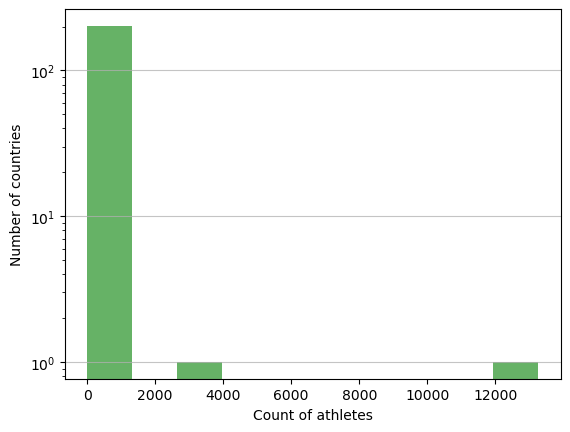

In [567]:
df_country['count'].plot(kind = 'hist', logy = True, color = 'green', alpha = 0.6)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Count of athletes')
plt.ylabel('Number of countries')

# Download results for athletes

### Active year per athlete

In [581]:
#downloading page sources for athletes
soup_ath = []
for i in range(len(df)):
    soup_ath.append(BeautifulSoup(requests.get(df['url_athlete'][i]).content))

In [582]:
#dictionary - number of athlete: list of active year
dict_year = {}
for i in range(len(df)):
    if len(str(BeautifulSoup(requests.get(df['url_athlete'][i]).content)).split('activeSeasons":')) <= 1:
        dict_year[df['number'][i]] = None
    else:
        dict_year[df['number'][i]] = json.loads(str(BeautifulSoup(requests.get(df['url_athlete'][i]).content)).split('activeSeasons":')[1].split(']')[0] + ']')

In [585]:
#new dictionary - double list 
dict_year2 = {}
for i in range(len(df)):
    dict_year2[df['number'][i]] = ([(dict_year[df['number'][i]])])

In [606]:
#dictionary to DataFrame
df_years = pd.DataFrame(dict_year2)
df_years = df_years.T
df_years = df_years.rename(columns = {0: 'active_years'})

### Results per athlete

In [590]:
header={
"accept": "*/*",
"accept-encoding": "gzip, deflate, br",
"content-length": "934",
"content-type": "application/json",
"origin": "https://www.worldathletics.org",
"referer": "https://www.worldathletics.org",
"sec-ch-ua-mobile": "?0",
"sec-ch-ua-platform": "macOS",
"sec-fetch-dest": "empty",
"sec-fetch-mode": "cors",
"sec-fetch-site": "cross-site",
"user-agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/107.0.0.0 Safari/537.36",
"x-amz-user-agent": "aws-amplify/3.0.2",
"x-api-key": "da2-ccv5yvixizdjdjtengkq2sbgsm"
}
url="https://2mlp5vgc7ffwlb763jx7yrizqu.appsync-api.eu-west-1.amazonaws.com/graphql"

In [591]:
def create_payload(y, idx):
    payload={
        "operationName":"GetSingleCompetitorResultsDiscipline",
        "variables":{
            "resultsByYear":y,
            "resultsByYearOrderBy":"discipline",
            "id":idx},
        "query":"query GetSingleCompetitorResultsDiscipline($id: Int, $resultsByYearOrderBy: String, $resultsByYear: Int) {\n  getSingleCompetitorResultsDiscipline(id: $id, resultsByYear: $resultsByYear, resultsByYearOrderBy: $resultsByYearOrderBy) {\n    parameters {\n      resultsByYear\n      resultsByYearOrderBy\n      __typename\n    }\n    activeYears\n    resultsByEvent {\n      indoor\n      disciplineCode\n      disciplineNameUrlSlug\n      typeNameUrlSlug\n      discipline\n      withWind\n      results {\n        date\n        competition\n        venue\n        country\n        category\n        race\n        place\n        mark\n        wind\n        notLegal\n        resultScore\n        remark\n        __typename\n      }\n      __typename\n    }\n    __typename\n  }\n}\n"}
    return payload

In [594]:
#downloading all results from the website
results = {}
for i in range(len(df)):
    lis = []
    for j in range(len(dict_year[list(dict_year.keys())[i]])):
        number = str(list(dict_year.keys())[i])              #athelete identification
        year = dict_year[list(dict_year.keys())[i]][j]       #results for the year
        pay = create_payload(year, number)
        resp = requests.post(url, headers=header, json=pay)
        
        competition = resp.json()['data']['getSingleCompetitorResultsDiscipline']['resultsByEvent']   
        
        for s in range(len(competition)):         #only 100m outdoor, not indoor
            if competition[s]['indoor'] == False and competition[s]['disciplineCode'] == '100':
                lis.append(resp.json()['data']['getSingleCompetitorResultsDiscipline']['resultsByEvent'][s]['results'])
    results[int(number)] = lis
results

KeyError: 'data'

In [614]:
#creating a list, and inside a dictionary with results, competitor number, date of competition, place of competition (city and country) and wind
competition_results = []
for k in range(len(df)):
    for i in range(len(results[df['number'][k]])):
        for j in range(len(results[df['number'][k]][i])):
            number = df['number'][k]
            result = results[df['number'][k]][i][j]['mark']
            date = results[df['number'][k]][i][j]['date']
            place = results[df['number'][k]][i][j]['venue']
            city = place.split(' (')[0].split(', ')[-1]
            country = place.split('(')[1][:3]
            wind = results[df['number'][k]][i][j]['wind']

            competition_results.append({'number': number, 'result':result, 'date_competition': date, 'country_competition': country, 'city_competition':city, 'wind':wind})

In [615]:
#convert list to DataFrame
df_results = pd.DataFrame(data = competition_results)

In [616]:
#change type of date from str to datetime
date = change_date(df_results['date_competition'])

In [634]:
df_results['date_competition'] = date

In [702]:
#convert date to pandas datetime
df_results['date_competition'] = [pd.to_datetime(x) for x in df_results['date_competition']]

In [735]:
#change country abbreviations to a long country name
df_results['abb_country_competition'] = df_results['abb_country_competition'].str.lower()
df_results['country_competition'] = change_country(df_results['abb_country_competition'])

In [734]:
#fix incorrectly assigned city and country
df_results[df_results['abb_country_competition'] == 'fri']['abb_country_competition'] = 'usa'
df_results['city_competition'][df_results['city_competition'] == 'Adair Austin Stadium'] = 'KS'

C:\Users\adasz\AppData\Local\Temp\ipykernel_10804\616512675.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_results['city_competition'][df_results['city_competition'] == 'Adair Austin Stadium'] = 'KS'


In [736]:
df_results

,number,result,date_competition,abb_country_competition,city_competition,wind,country_competition
0,14164603,11.40,2009-07-23,srb,Novi Sad,-2.3,Serbia
1,14164603,11.09,2010-07-09,est,Kose,+2.1,Estonia
2,14164603,11.23,2010-07-16,est,Tallinn,+2.4,Estonia
3,14164603,11.21,2010-07-16,est,Tallinn,-0.7,Estonia
4,14164603,10.93,2011-06-04,fin,Seinäjoki,+2.8,Finland
...,...,...,...,...,...,...,...
581272,15054047,10.88,2022-11-03,jpn,Omuta,+1.5,Japan
581273,15054107,10.71,2022-10-09,jpn,Yokohama,+1.8,Japan
581274,15054107,10.79,2022-10-09,jpn,Yokohama,+1.1,Japan
581275,15054126,10.96,2022-10-15,jpn,Kanazawa,+0.4,Japan


# Merge athlete to results

In [847]:
df_all = pd.merge(df, df_results, on = 'number')
df_all

,name,country,abb_coun,number,birth_date,url_athlete,result,date_competition,abb_country_competition,city_competition,wind,country_competition
0,Usain BOLT,Jamaica,jam,14201847,1986-08-21,https://www.worldathletics.org/athletes/Jamaic...,10.03,2007-07-18,gre,Rethymno,+0.7,Greece
1,Usain BOLT,Jamaica,jam,14201847,1986-08-21,https://www.worldathletics.org/athletes/Jamaic...,10.03,2008-03-08,jam,Spanish Town,+1.8,Jamaica
2,Usain BOLT,Jamaica,jam,14201847,1986-08-21,https://www.worldathletics.org/athletes/Jamaic...,9.76,2008-05-03,jam,Kingston,+1.8,Jamaica
3,Usain BOLT,Jamaica,jam,14201847,1986-08-21,https://www.worldathletics.org/athletes/Jamaic...,9.92,2008-05-17,tto,Port-of-Spain,+0.6,Trinidad and Tobago
4,Usain BOLT,Jamaica,jam,14201847,1986-08-21,https://www.worldathletics.org/athletes/Jamaic...,9.72,2008-05-31,usa,NY,+1.7,United States
...,...,...,...,...,...,...,...,...,...,...,...,...
581272,Rohan GHOSH,India,ind,15045591,2005-05-30,https://www.worldathletics.org/athletes/India/...,11.22,2022-09-10,ind,Patna,NWI,India
581273,Rohan GHOSH,India,ind,15045591,2005-05-30,https://www.worldathletics.org/athletes/India/...,10.98,2022-09-10,ind,Patna,NWI,India
581274,Rohan GHOSH,India,ind,15045591,2005-05-30,https://www.worldathletics.org/athletes/India/...,11.12,2022-09-17,ind,Bhopal,-0.7,India
581275,Rohan GHOSH,India,ind,15045591,2005-05-30,https://www.worldathletics.org/athletes/India/...,11.00,2022-11-11,ind,Guwahati,0.0,India


### Age

In [848]:
#the age of the competitor at the time of the competition - age converted into years
age = [round((df_all['date_competition'][i] - df_all['birth_date'][i]).days/365, 2) for i in range(len(df_all))]
df_all['age'] = age
df_all

,name,country,abb_coun,number,birth_date,url_athlete,result,date_competition,abb_country_competition,city_competition,wind,country_competition,age
0,Usain BOLT,Jamaica,jam,14201847,1986-08-21,https://www.worldathletics.org/athletes/Jamaic...,10.03,2007-07-18,gre,Rethymno,+0.7,Greece,20.92
1,Usain BOLT,Jamaica,jam,14201847,1986-08-21,https://www.worldathletics.org/athletes/Jamaic...,10.03,2008-03-08,jam,Spanish Town,+1.8,Jamaica,21.56
2,Usain BOLT,Jamaica,jam,14201847,1986-08-21,https://www.worldathletics.org/athletes/Jamaic...,9.76,2008-05-03,jam,Kingston,+1.8,Jamaica,21.72
3,Usain BOLT,Jamaica,jam,14201847,1986-08-21,https://www.worldathletics.org/athletes/Jamaic...,9.92,2008-05-17,tto,Port-of-Spain,+0.6,Trinidad and Tobago,21.75
4,Usain BOLT,Jamaica,jam,14201847,1986-08-21,https://www.worldathletics.org/athletes/Jamaic...,9.72,2008-05-31,usa,NY,+1.7,United States,21.79
...,...,...,...,...,...,...,...,...,...,...,...,...,...
581272,Rohan GHOSH,India,ind,15045591,2005-05-30,https://www.worldathletics.org/athletes/India/...,11.22,2022-09-10,ind,Patna,NWI,India,17.29
581273,Rohan GHOSH,India,ind,15045591,2005-05-30,https://www.worldathletics.org/athletes/India/...,10.98,2022-09-10,ind,Patna,NWI,India,17.29
581274,Rohan GHOSH,India,ind,15045591,2005-05-30,https://www.worldathletics.org/athletes/India/...,11.12,2022-09-17,ind,Bhopal,-0.7,India,17.31
581275,Rohan GHOSH,India,ind,15045591,2005-05-30,https://www.worldathletics.org/athletes/India/...,11.00,2022-11-11,ind,Guwahati,0.0,India,17.46


### If country of birth and competition is the same

In [849]:
#comparison whether the competitor competed in the country of origin or not
if_country = [1 if df_all['abb_coun'][i] == df_all['abb_country_competition'][i] else 0 for i in range(len(df_all))]
df_all['if_country'] = if_country
df_all

,name,country,abb_coun,number,birth_date,url_athlete,result,date_competition,abb_country_competition,city_competition,wind,country_competition,age,if_country
0,Usain BOLT,Jamaica,jam,14201847,1986-08-21,https://www.worldathletics.org/athletes/Jamaic...,10.03,2007-07-18,gre,Rethymno,+0.7,Greece,20.92,0
1,Usain BOLT,Jamaica,jam,14201847,1986-08-21,https://www.worldathletics.org/athletes/Jamaic...,10.03,2008-03-08,jam,Spanish Town,+1.8,Jamaica,21.56,1
2,Usain BOLT,Jamaica,jam,14201847,1986-08-21,https://www.worldathletics.org/athletes/Jamaic...,9.76,2008-05-03,jam,Kingston,+1.8,Jamaica,21.72,1
3,Usain BOLT,Jamaica,jam,14201847,1986-08-21,https://www.worldathletics.org/athletes/Jamaic...,9.92,2008-05-17,tto,Port-of-Spain,+0.6,Trinidad and Tobago,21.75,0
4,Usain BOLT,Jamaica,jam,14201847,1986-08-21,https://www.worldathletics.org/athletes/Jamaic...,9.72,2008-05-31,usa,NY,+1.7,United States,21.79,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581272,Rohan GHOSH,India,ind,15045591,2005-05-30,https://www.worldathletics.org/athletes/India/...,11.22,2022-09-10,ind,Patna,NWI,India,17.29,1
581273,Rohan GHOSH,India,ind,15045591,2005-05-30,https://www.worldathletics.org/athletes/India/...,10.98,2022-09-10,ind,Patna,NWI,India,17.29,1
581274,Rohan GHOSH,India,ind,15045591,2005-05-30,https://www.worldathletics.org/athletes/India/...,11.12,2022-09-17,ind,Bhopal,-0.7,India,17.31,1
581275,Rohan GHOSH,India,ind,15045591,2005-05-30,https://www.worldathletics.org/athletes/India/...,11.00,2022-11-11,ind,Guwahati,0.0,India,17.46,1


### Year of competition

In [850]:
year = [y.year for y in df_all['date_competition']]
df_all['year'] = year
df_all

,name,country,abb_coun,number,birth_date,url_athlete,result,date_competition,abb_country_competition,city_competition,wind,country_competition,age,if_country,year
0,Usain BOLT,Jamaica,jam,14201847,1986-08-21,https://www.worldathletics.org/athletes/Jamaic...,10.03,2007-07-18,gre,Rethymno,+0.7,Greece,20.92,0,2007
1,Usain BOLT,Jamaica,jam,14201847,1986-08-21,https://www.worldathletics.org/athletes/Jamaic...,10.03,2008-03-08,jam,Spanish Town,+1.8,Jamaica,21.56,1,2008
2,Usain BOLT,Jamaica,jam,14201847,1986-08-21,https://www.worldathletics.org/athletes/Jamaic...,9.76,2008-05-03,jam,Kingston,+1.8,Jamaica,21.72,1,2008
3,Usain BOLT,Jamaica,jam,14201847,1986-08-21,https://www.worldathletics.org/athletes/Jamaic...,9.92,2008-05-17,tto,Port-of-Spain,+0.6,Trinidad and Tobago,21.75,0,2008
4,Usain BOLT,Jamaica,jam,14201847,1986-08-21,https://www.worldathletics.org/athletes/Jamaic...,9.72,2008-05-31,usa,NY,+1.7,United States,21.79,0,2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581272,Rohan GHOSH,India,ind,15045591,2005-05-30,https://www.worldathletics.org/athletes/India/...,11.22,2022-09-10,ind,Patna,NWI,India,17.29,1,2022
581273,Rohan GHOSH,India,ind,15045591,2005-05-30,https://www.worldathletics.org/athletes/India/...,10.98,2022-09-10,ind,Patna,NWI,India,17.29,1,2022
581274,Rohan GHOSH,India,ind,15045591,2005-05-30,https://www.worldathletics.org/athletes/India/...,11.12,2022-09-17,ind,Bhopal,-0.7,India,17.31,1,2022
581275,Rohan GHOSH,India,ind,15045591,2005-05-30,https://www.worldathletics.org/athletes/India/...,11.00,2022-11-11,ind,Guwahati,0.0,India,17.46,1,2022


### Career start number

In [851]:
#sort needed for grouping
df_all = df_all.sort_values(['number', 'date_competition']).reset_index().drop(columns = 'index')
df_all

,name,country,abb_coun,number,birth_date,url_athlete,result,date_competition,abb_country_competition,city_competition,wind,country_competition,age,if_country,year
0,Kaarel JÕEVÄLI,Estonia,est,14164603,1990-01-08,https://www.worldathletics.org/athletes/Estoni...,11.40,2009-07-23,srb,Novi Sad,-2.3,Serbia,19.55,0,2009
1,Kaarel JÕEVÄLI,Estonia,est,14164603,1990-01-08,https://www.worldathletics.org/athletes/Estoni...,11.09,2010-07-09,est,Kose,+2.1,Estonia,20.51,1,2010
2,Kaarel JÕEVÄLI,Estonia,est,14164603,1990-01-08,https://www.worldathletics.org/athletes/Estoni...,11.23,2010-07-16,est,Tallinn,+2.4,Estonia,20.53,1,2010
3,Kaarel JÕEVÄLI,Estonia,est,14164603,1990-01-08,https://www.worldathletics.org/athletes/Estoni...,11.21,2010-07-16,est,Tallinn,-0.7,Estonia,20.53,1,2010
4,Kaarel JÕEVÄLI,Estonia,est,14164603,1990-01-08,https://www.worldathletics.org/athletes/Estoni...,10.93,2011-06-04,fin,Seinäjoki,+2.8,Finland,21.42,0,2011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581272,Kotaro YAMAMOTO,Japan,jpn,15054047,2005-10-04,https://www.worldathletics.org/athletes/Japan/...,10.88,2022-11-03,jpn,Omuta,+1.5,Japan,17.09,1,2022
581273,Kazuya IWATA,Japan,jpn,15054107,2005-06-25,https://www.worldathletics.org/athletes/Japan/...,10.71,2022-10-09,jpn,Yokohama,+1.8,Japan,17.30,1,2022
581274,Kazuya IWATA,Japan,jpn,15054107,2005-06-25,https://www.worldathletics.org/athletes/Japan/...,10.79,2022-10-09,jpn,Yokohama,+1.1,Japan,17.30,1,2022
581275,Subiarann MUGABI,Japan,jpn,15054126,2004-03-01,https://www.worldathletics.org/athletes/Japan/...,10.96,2022-10-15,jpn,Kanazawa,+0.4,Japan,18.64,1,2022


In [852]:
#starting number in the career of one competitor, grouping by number
how_per_career = list(df_all.groupby(['number']).size().reset_index(name = 'career')['career'])

In [853]:
start_career = []
for how in how_per_career:
    for j in range(how):
        start_career.append(j+1)

In [854]:
df_all['start_career'] = start_career
df_all

,name,country,abb_coun,number,birth_date,url_athlete,result,date_competition,abb_country_competition,city_competition,wind,country_competition,age,if_country,year,start_career
0,Kaarel JÕEVÄLI,Estonia,est,14164603,1990-01-08,https://www.worldathletics.org/athletes/Estoni...,11.40,2009-07-23,srb,Novi Sad,-2.3,Serbia,19.55,0,2009,1
1,Kaarel JÕEVÄLI,Estonia,est,14164603,1990-01-08,https://www.worldathletics.org/athletes/Estoni...,11.09,2010-07-09,est,Kose,+2.1,Estonia,20.51,1,2010,2
2,Kaarel JÕEVÄLI,Estonia,est,14164603,1990-01-08,https://www.worldathletics.org/athletes/Estoni...,11.23,2010-07-16,est,Tallinn,+2.4,Estonia,20.53,1,2010,3
3,Kaarel JÕEVÄLI,Estonia,est,14164603,1990-01-08,https://www.worldathletics.org/athletes/Estoni...,11.21,2010-07-16,est,Tallinn,-0.7,Estonia,20.53,1,2010,4
4,Kaarel JÕEVÄLI,Estonia,est,14164603,1990-01-08,https://www.worldathletics.org/athletes/Estoni...,10.93,2011-06-04,fin,Seinäjoki,+2.8,Finland,21.42,0,2011,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581272,Kotaro YAMAMOTO,Japan,jpn,15054047,2005-10-04,https://www.worldathletics.org/athletes/Japan/...,10.88,2022-11-03,jpn,Omuta,+1.5,Japan,17.09,1,2022,1
581273,Kazuya IWATA,Japan,jpn,15054107,2005-06-25,https://www.worldathletics.org/athletes/Japan/...,10.71,2022-10-09,jpn,Yokohama,+1.8,Japan,17.30,1,2022,1
581274,Kazuya IWATA,Japan,jpn,15054107,2005-06-25,https://www.worldathletics.org/athletes/Japan/...,10.79,2022-10-09,jpn,Yokohama,+1.1,Japan,17.30,1,2022,2
581275,Subiarann MUGABI,Japan,jpn,15054126,2004-03-01,https://www.worldathletics.org/athletes/Japan/...,10.96,2022-10-15,jpn,Kanazawa,+0.4,Japan,18.64,1,2022,1


### Season start number

In [855]:
#starting number in the season of one competitor, grouping by number and year
how_per_season = list(df_all.groupby(['number', 'year']).size().reset_index(name = 'season')['season'])

In [856]:
start_season = []
for how in how_per_season:
    for j in range(how):
        start_season.append(j+1)

In [857]:
df_all['start_season'] = start_season
df_all

,name,country,abb_coun,number,birth_date,url_athlete,result,date_competition,abb_country_competition,city_competition,wind,country_competition,age,if_country,year,start_career,start_season
0,Kaarel JÕEVÄLI,Estonia,est,14164603,1990-01-08,https://www.worldathletics.org/athletes/Estoni...,11.40,2009-07-23,srb,Novi Sad,-2.3,Serbia,19.55,0,2009,1,1
1,Kaarel JÕEVÄLI,Estonia,est,14164603,1990-01-08,https://www.worldathletics.org/athletes/Estoni...,11.09,2010-07-09,est,Kose,+2.1,Estonia,20.51,1,2010,2,1
2,Kaarel JÕEVÄLI,Estonia,est,14164603,1990-01-08,https://www.worldathletics.org/athletes/Estoni...,11.23,2010-07-16,est,Tallinn,+2.4,Estonia,20.53,1,2010,3,2
3,Kaarel JÕEVÄLI,Estonia,est,14164603,1990-01-08,https://www.worldathletics.org/athletes/Estoni...,11.21,2010-07-16,est,Tallinn,-0.7,Estonia,20.53,1,2010,4,3
4,Kaarel JÕEVÄLI,Estonia,est,14164603,1990-01-08,https://www.worldathletics.org/athletes/Estoni...,10.93,2011-06-04,fin,Seinäjoki,+2.8,Finland,21.42,0,2011,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581272,Kotaro YAMAMOTO,Japan,jpn,15054047,2005-10-04,https://www.worldathletics.org/athletes/Japan/...,10.88,2022-11-03,jpn,Omuta,+1.5,Japan,17.09,1,2022,1,1
581273,Kazuya IWATA,Japan,jpn,15054107,2005-06-25,https://www.worldathletics.org/athletes/Japan/...,10.71,2022-10-09,jpn,Yokohama,+1.8,Japan,17.30,1,2022,1,1
581274,Kazuya IWATA,Japan,jpn,15054107,2005-06-25,https://www.worldathletics.org/athletes/Japan/...,10.79,2022-10-09,jpn,Yokohama,+1.1,Japan,17.30,1,2022,2,2
581275,Subiarann MUGABI,Japan,jpn,15054126,2004-03-01,https://www.worldathletics.org/athletes/Japan/...,10.96,2022-10-15,jpn,Kanazawa,+0.4,Japan,18.64,1,2022,1,1


### Wind

convert str to float

In [858]:
#checking if all values are numeric
df_all['wind'].unique()

array(['-2.3', '+2.1', '+2.4', '-0.7', '+2.8', '+1.2', '-1.2', '+0.2',
       '-0.9', '+0.9', '+3.8', '+3.2', '+3.1', '-0.2', '+1.5', '-1.8',
       '-2.5', '-1.5', '+1.1', '-1.7', '0.0', '+2.2', '+3.4', '+1.0',
       '+1.6', '+1.4', '+0.4', '+1.9', '+1.3', '+2.7', '+2.6', '+0.3',
       '+0.6', '-0.4', '+0.7', '-0.5', '+1.7', '+2.0', '-1.3', '+0.8',
       nan, '+3.5', '-0.6', '+1.8', '-1.6', '+0.1', '-1.9', '-0.3',
       '+2.5', '+0.5', '-2.8', '-1.4', '-1.0', '-4.6', '-0.1', '+2.3',
       '-3.7', '+5.0', '-2.0', '+4.9', '+4.2', '+3.6', '-2.9', '-1.1',
       '-0.8', '-3.3', '+4.4', '+3.0', '+3.3', 'NWI', '+5.2', '-2.1',
       '+7.3', '+7.0', '+2.9', '+3.7', '-2.6', '-5.3', '-2.7', '-3.1',
       '+4.5', '-3.4', '+3.9', '+4.0', 'w', '+4.1', '-2.4', '+5.4',
       '-3.0', '-3.6', '-2.2', '+4.8', '+4.3', '-8.6', '+4.6', '+5.1',
       '+6.0', '+6.6', '-4.2', '-4.8', '+5.9', '+7.5', '+6.1', '-3.8',
       '-3.9', '+5.8', '-3.5', '+5.5', '-3.2', '+4.7', '-4.4', '-4.7',
       '+5.3',

In [859]:
#there are 'NWI' and 'w' values that need to be converted to nan
df_all['wind'] = df_all.apply(lambda row: np.nan if row['wind'] == 'NWI' or row['wind'] == 'w' else row['wind'], axis=1)

In [860]:
df_all['wind'] = df_all['wind'].astype(float)

### current PB/ SB - wind included

PB - personal best, SB - season best

personal/seasonal bests in sprints are recognized if the wind blows at a maximum of 2 m/s

In [814]:
def actual_record(col_start, col_wind, col_result):
    rec_list = []
    s = 0
    for w in range(len(col_start)):
        if col_start[w] == 1:
            rec_list.append([np.nan])
            s = s + 1
            if type(rec_list[s-1][-1]) != float:
                print(s, rec_list[s-1][-1])

        elif col_start[w] > 1 and (col_wind[w-1] > 2 or m.isnan(col_wind[w-1])) and m.isnan(rec_list[s-1][-1]):
            rec_list.append([np.nan])
            s = s+1

        elif s > 0 and (col_wind[w-1] > 2 or m.isnan(col_wind[w-1])) and m.isnan(rec_list[s-1][-1]) is False:
            rec_list[s-1].append(rec_list[s-1][-1])

        else:
            rec_list[s-1].append(col_result[w-1])
            
    rec_list2 = []
    for t in range(len(rec_list)):
        rec_list2.append(rec_list[t][0])
        if len(rec_list[t]) == 2:
            rec_list2.append(rec_list[t][1])
        elif len(rec_list[t]) > 2:
            rec_list2.append(rec_list[t][1])
            mini = rec_list[t][1]
            for j in range(2, len(rec_list[t])):
                if rec_list[t][j] < mini:
                    mini = rec_list[t][j]
                rec_list2.append(mini)
    return(rec_list2)

In [861]:
pb_record = actual_record(df_all['start_career'], df_all['wind'], df_all['result'])

In [862]:
sb_record = actual_record(df_all['start_season'], df_all['wind'], df_all['result'])

In [865]:
df_all['pb'] = pb_record
df_all['sb'] = sb_record

In [866]:
df_all

,name,country,abb_coun,number,birth_date,url_athlete,result,date_competition,abb_country_competition,city_competition,wind,country_competition,age,if_country,year,start_career,start_season,pb,sb
0,Kaarel JÕEVÄLI,Estonia,est,14164603,1990-01-08,https://www.worldathletics.org/athletes/Estoni...,11.40,2009-07-23,srb,Novi Sad,-2.3,Serbia,19.55,0,2009,1,1,NaN,NaN
1,Kaarel JÕEVÄLI,Estonia,est,14164603,1990-01-08,https://www.worldathletics.org/athletes/Estoni...,11.09,2010-07-09,est,Kose,2.1,Estonia,20.51,1,2010,2,1,11.40,NaN
2,Kaarel JÕEVÄLI,Estonia,est,14164603,1990-01-08,https://www.worldathletics.org/athletes/Estoni...,11.23,2010-07-16,est,Tallinn,2.4,Estonia,20.53,1,2010,3,2,11.40,NaN
3,Kaarel JÕEVÄLI,Estonia,est,14164603,1990-01-08,https://www.worldathletics.org/athletes/Estoni...,11.21,2010-07-16,est,Tallinn,-0.7,Estonia,20.53,1,2010,4,3,11.40,NaN
4,Kaarel JÕEVÄLI,Estonia,est,14164603,1990-01-08,https://www.worldathletics.org/athletes/Estoni...,10.93,2011-06-04,fin,Seinäjoki,2.8,Finland,21.42,0,2011,5,1,11.21,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581272,Kotaro YAMAMOTO,Japan,jpn,15054047,2005-10-04,https://www.worldathletics.org/athletes/Japan/...,10.88,2022-11-03,jpn,Omuta,1.5,Japan,17.09,1,2022,1,1,NaN,NaN
581273,Kazuya IWATA,Japan,jpn,15054107,2005-06-25,https://www.worldathletics.org/athletes/Japan/...,10.71,2022-10-09,jpn,Yokohama,1.8,Japan,17.30,1,2022,1,1,NaN,NaN
581274,Kazuya IWATA,Japan,jpn,15054107,2005-06-25,https://www.worldathletics.org/athletes/Japan/...,10.79,2022-10-09,jpn,Yokohama,1.1,Japan,17.30,1,2022,2,2,10.71,10.71
581275,Subiarann MUGABI,Japan,jpn,15054126,2004-03-01,https://www.worldathletics.org/athletes/Japan/...,10.96,2022-10-15,jpn,Kanazawa,0.4,Japan,18.64,1,2022,1,1,NaN,NaN


### Height above sea level

The height at which the runners run affects their well-being as well as the results, a csv file was found that shows the average height above sea level for countries.

In [935]:
df_height = pd.read_csv(r'Data\country_height.csv', sep = ';')   
df_height

,country,height
0,Afghanistan,"1,884 m (6,181 ft)"
1,Albania,"708 m (2,323 ft)"
2,Algeria,"800 m (2,625 ft)"
3,Andorra,"1,996 m (6,549 ft)"
4,Angola,"1,112 m (3,648 ft)"
...,...,...
167,Vietnam,"398 m (1,306 ft)"
168,Western Sahara,256 m (840 ft)
169,Yemen,"999 m (3,278 ft)"
170,Zambia,"1,138 m (3,734 ft)"


In [936]:
#convert height from str to float
def fun_height(t):
    if 'm' in t:
        t = t.split('m')[0]
    if ',' in t:
        t = t.replace(',','')
    t = int(float(t))
    return t

df_height['height'] = df_height['height'].apply(fun_height)
df_height = df_height.rename(columns = {'country': 'country_competition'})
df_height

,country_competition,height
0,Afghanistan,1884
1,Albania,708
2,Algeria,800
3,Andorra,1996
4,Angola,1112
...,...,...
167,Vietnam,398
168,Western Sahara,256
169,Yemen,999
170,Zambia,1138


In [937]:
#merge DataFrames: df_height and df_all
df_all2 = pd.merge(df_all, df_height, how="left", on=["country_competition"])
df_all2

,name,country,abb_coun,number,birth_date,url_athlete,result,date_competition,abb_country_competition,city_competition,wind,country_competition,age,if_country,year,start_career,start_season,pb,sb,height
0,Kaarel JÕEVÄLI,Estonia,est,14164603,1990-01-08,https://www.worldathletics.org/athletes/Estoni...,11.40,2009-07-23,srb,Novi Sad,-2.3,Serbia,19.55,0,2009,1,1,NaN,NaN,473.0
1,Kaarel JÕEVÄLI,Estonia,est,14164603,1990-01-08,https://www.worldathletics.org/athletes/Estoni...,11.09,2010-07-09,est,Kose,2.1,Estonia,20.51,1,2010,2,1,11.40,NaN,61.0
2,Kaarel JÕEVÄLI,Estonia,est,14164603,1990-01-08,https://www.worldathletics.org/athletes/Estoni...,11.23,2010-07-16,est,Tallinn,2.4,Estonia,20.53,1,2010,3,2,11.40,NaN,61.0
3,Kaarel JÕEVÄLI,Estonia,est,14164603,1990-01-08,https://www.worldathletics.org/athletes/Estoni...,11.21,2010-07-16,est,Tallinn,-0.7,Estonia,20.53,1,2010,4,3,11.40,NaN,61.0
4,Kaarel JÕEVÄLI,Estonia,est,14164603,1990-01-08,https://www.worldathletics.org/athletes/Estoni...,10.93,2011-06-04,fin,Seinäjoki,2.8,Finland,21.42,0,2011,5,1,11.21,NaN,164.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581272,Kotaro YAMAMOTO,Japan,jpn,15054047,2005-10-04,https://www.worldathletics.org/athletes/Japan/...,10.88,2022-11-03,jpn,Omuta,1.5,Japan,17.09,1,2022,1,1,NaN,NaN,438.0
581273,Kazuya IWATA,Japan,jpn,15054107,2005-06-25,https://www.worldathletics.org/athletes/Japan/...,10.71,2022-10-09,jpn,Yokohama,1.8,Japan,17.30,1,2022,1,1,NaN,NaN,438.0
581274,Kazuya IWATA,Japan,jpn,15054107,2005-06-25,https://www.worldathletics.org/athletes/Japan/...,10.79,2022-10-09,jpn,Yokohama,1.1,Japan,17.30,1,2022,2,2,10.71,10.71,438.0
581275,Subiarann MUGABI,Japan,jpn,15054126,2004-03-01,https://www.worldathletics.org/athletes/Japan/...,10.96,2022-10-15,jpn,Kanazawa,0.4,Japan,18.64,1,2022,1,1,NaN,NaN,438.0


In [939]:
#list of countries for which the height has not been assigned
country_without_height = set(df_all2['country_competition'][df_all2['height'].isna()])
print(country_without_height, len(country_without_height))

{'Bahrain', 'Democratic Republic of Congo', 'Northern Mariana Islands', 'Korea', 'Malta', 'Macao, China', 'Yugoslavia', 'Saint Lucia', 'Saint Kitts and Nevis', 'Norfolk Island', 'Guam', 'Turks and Caicos Islands', 'Grenada', 'Fiji', 'Bosnia-Herzegovina', 'Netherlands Antilles', 'Bermuda', 'DPR of Korea', 'American Samoa', 'Surinam', 'Republic of North Macedonia', 'Zsrr', 'Côte d’Ivoire', 'British Virgin Islands', 'Liechtenstein', 'Türkiye', 'French Polynesia', 'Great Britain & N.I.', 'Czechoslovakia', 'Gibraltar', 'San Marino', 'Monaco', 'Bahamas', 'Hong Kong, China', 'Saint Vincent', 'Slovak Republic', 'Cayman Islands', 'PR of China', 'Rfn', 'Tonga', 'Samoa', 'Congo', 'Nrd', 'Islamic Republic of Iran', 'Mauritius', 'Barbados', 'Cook Islands', 'Aruba', 'Micronesia', 'Chinese Taipei', 'Puerto Rico'} 51


In [940]:
#some countries had different names in the two DataFrame so in df_height the names were changed
df_height = df_height.replace('Bosnia and Herzegovina', 'Bosnia-Herzegovina')
df_height = df_height.replace('Taiwan', 'Chinese Taipei')
df_height = df_height.replace('Republic of the Congo', 'Congo')
df_height = df_height.replace('Ivory Coast', 'Côte d’Ivoire')
df_height = df_height.replace('North Korea', 'DPR of Korea')
df_height = df_height.replace('Democratic Republic of the Congo', 'Democratic Republic of Congo')
df_height = df_height.replace('United Kingdom', 'Great Britain & N.I.')
df_height = df_height.replace('Iran', 'Islamic Republic of Iran')
df_height = df_height.replace('Kirghizistan', 'Kyrgyzstan')
df_height = df_height.replace('South Korea', 'Korea')
df_height = df_height.replace('China', 'PR of China')
df_height = df_height.replace('North Macedonia', 'Republic of North Macedonia')
df_height = df_height.replace('Slovakia', 'Slovak Republic')
df_height = df_height.replace('Suriname', 'Surinam')
df_height = df_height.replace('Gambia', 'The Gambia')
df_height = df_height.replace('Turkey', 'Türkiye')

In [941]:
#for some countries an average height was found or calculated as an average: Czechoslovakia = (Czech Republic + Slovakia)/2
countries = ['Anguilla', 'Antigua & Barbuda', 'Bahamas', 'Bahrain', 'Barbados', 'Bermuda', 'Commonwealth of Dominica', 'Comoros', 'Czechoslovakia', 'Fiji', 'French Polynesia', 'Grenada', 'Hong Kong, China', 'Macao, China', 'Malta', 'Mauritius', 'Micronesia', 'Monaco', 'Netherlands Antilles', 'Nrd', 'Palau', 'Puerto Rico', 'Rfn', 'Saint Kitts and Nevis', 'San Marino', 'Sao Tome & Principe', 'Serbia and Montenegro', 'Seychelles', 'Solomon Islands', 'Tonga', 'Liechtenstein', 'Norfolk Island']
height = [33, 202, 32, 61, 180, 45, 850, 29, 444, 662, 1121, 420, 479, 114, 127, 1100, 2, 81, 30, 263, 121, 261, 263, 578, 749, 2024, 780, 453, 1166, 517, 453, 213]

In [942]:
for i in range(len(countries)):
    counry_height = {'country_competition': countries[i], 'height': height[i]}
    df_height = df_height.append(counry_height, ignore_index=True)

C:\Users\adasz\AppData\Local\Temp\ipykernel_10804\779162748.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_height = df_height.append(counry_height, ignore_index=True)
C:\Users\adasz\AppData\Local\Temp\ipykernel_10804\779162748.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_height = df_height.append(counry_height, ignore_index=True)
C:\Users\adasz\AppData\Local\Temp\ipykernel_10804\779162748.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_height = df_height.append(counry_height, ignore_index=True)
C:\Users\adasz\AppData\Local\Temp\ipykernel_10804\779162748.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_heig

In [943]:
#reconnecting after repair and adding height for countries
df_all2 = pd.merge(df_all, df_height, how="left", on=["country_competition"])

In [944]:
#only 14 countries without height
country_without_height = set(df_all2['country_competition'][df_all2['height'].isna()])
print(country_without_height, len(country_without_height))

{'Cayman Islands', 'British Virgin Islands', 'Turks and Caicos Islands', 'Guam', 'Northern Mariana Islands', 'Gibraltar', 'Samoa', 'Yugoslavia', 'Saint Lucia', 'Cook Islands', 'Aruba', 'American Samoa', 'Saint Vincent', 'Zsrr'} 14


# Results analysis

In [952]:
df_all2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 581277 entries, 0 to 581276
Data columns (total 20 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   name                     581277 non-null  object        
 1   country                  581277 non-null  object        
 2   abb_coun                 581277 non-null  object        
 3   number                   581277 non-null  int64         
 4   birth_date               495759 non-null  datetime64[ns]
 5   url_athlete              581277 non-null  object        
 6   result                   581277 non-null  float64       
 7   date_competition         581277 non-null  datetime64[ns]
 8   abb_country_competition  581277 non-null  object        
 9   city_competition         581277 non-null  object        
 10  wind                     546387 non-null  float64       
 11  country_competition      581277 non-null  object        
 12  age             

### age analysis

In [953]:
#ok, 57 makes sense
df_all2['age'].max()

57.71

In [954]:
#error, age cannot be negative
df_all2['age'].min()

-10.1

In [955]:
#three situations where age is negative
#date of birth and dates of races agree with the data from the source (iaaf website), so the error is due to the data on website
#you can delete these records or replace the competition date and thus the age and year with nan
df_all2[df_all2['age'] < 0]

,name,country,abb_coun,number,birth_date,url_athlete,result,date_competition,abb_country_competition,city_competition,wind,country_competition,age,if_country,year,start_career,start_season,pb,sb,height
180546,Joe FRANKLIN,United States,usa,14344410,1978-07-11,https://www.worldathletics.org/athletes/United...,10.00,1976-05-01,usa,LA,NaN,United States,-2.19,1,1976,1,1,NaN,NaN,760.0
180547,Joe FRANKLIN,United States,usa,14344410,1978-07-11,https://www.worldathletics.org/athletes/United...,10.46,1976-06-11,usa,CA,0.9,United States,-2.08,1,1976,2,2,NaN,NaN,760.0
183657,Carl EDMUND,Panama,pan,14351322,1983-03-31,https://www.worldathletics.org/athletes/Panama...,10.40,1973-02-24,pan,Panama City,-0.8,Panama,-10.10,1,1973,1,1,NaN,NaN,360.0


Text(0.5, 1.0, 'Age histogram')

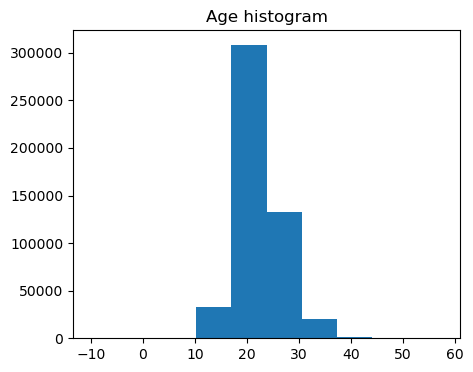

In [971]:
plt.figure(figsize=(5,4))
plt.hist(df_all2['age'])
plt.title('Age histogram')

In [962]:
#there are also isolated cases when age < 10 - in total 17
df_all2[df_all2['age'] < 10]

,name,country,abb_coun,number,birth_date,url_athlete,result,date_competition,abb_country_competition,city_competition,wind,country_competition,age,if_country,year,start_career,start_season,pb,sb,height
119752,Aleksandr CHIZHOV,Russia,rus,14222012,1991-02-18,https://www.worldathletics.org/athletes/Russia...,10.80,1998-05-30,rus,Bryansk,0.9,Russia,7.28,1,1998,1,1,NaN,NaN,600.0
133756,Burak KARAKAŞ,Türkiye,tur,14229403,2001-04-04,https://www.worldathletics.org/athletes/Türkiy...,11.00,2003-06-08,tur,Istanbul,0.8,Türkiye,2.18,1,2003,1,1,NaN,NaN,1141.0
134147,Dmytro BONDAREV,Ukraine,ukr,14229766,1993-10-03,https://www.worldathletics.org/athletes/Ukrain...,10.93,1999-05-14,ukr,Kyiv,0.2,Ukraine,5.61,1,1999,1,1,NaN,NaN,175.0
143977,Bobby EZELL,United States,usa,14237460,1989-01-01,https://www.worldathletics.org/athletes/United...,10.53,1998-05-15,usa,IL,2.5,United States,9.37,1,1998,1,1,NaN,NaN,760.0
160839,James SCOTT,United States,usa,14250820,1980-09-16,https://www.worldathletics.org/athletes/United...,10.47,1987-05-30,usa,MO,NaN,United States,6.70,1,1987,1,1,NaN,NaN,760.0
168563,Jemar JOHNSON,Jamaica,jam,14325646,2000-10-20,https://www.worldathletics.org/athletes/Jamaic...,10.82,2008-03-08,jam,Spanish Town,4.7,Jamaica,7.39,1,2008,1,1,NaN,NaN,340.0
168564,Jemar JOHNSON,Jamaica,jam,14325646,2000-10-20,https://www.worldathletics.org/athletes/Jamaic...,10.94,2009-03-14,jam,Spanish Town,NaN,Jamaica,8.40,1,2009,2,1,NaN,NaN,340.0
168565,Jemar JOHNSON,Jamaica,jam,14325646,2000-10-20,https://www.worldathletics.org/athletes/Jamaic...,10.80,2010-02-13,jam,Spanish Town,NaN,Jamaica,9.32,1,2010,3,1,NaN,NaN,340.0
168566,Jemar JOHNSON,Jamaica,jam,14325646,2000-10-20,https://www.worldathletics.org/athletes/Jamaic...,11.03,2010-03-13,jam,Spanish Town,1.7,Jamaica,9.40,1,2010,4,2,NaN,NaN,340.0
168567,Jemar JOHNSON,Jamaica,jam,14325646,2000-10-20,https://www.worldathletics.org/athletes/Jamaic...,11.05,2010-04-17,jam,Kingston,-2.0,Jamaica,9.50,1,2010,5,3,11.03,11.03,340.0


In [972]:
#searching for numbers of athletes who are < 10 years old. 
#If age < 0, the value is -1, if between 0 and 10, the value is 0, and if age > 10 value is 1.
numbers = []
def age_number(row):
    if row['age'] < 0:
        value = -1
    elif row['age'] >= 0 and row['age'] < 10:
        value = 0
        if row['number'] not in numbers:
            numbers.append(row['number'])
    else:
        value = 1    
    return value

df_all2['value'] = df_all2.apply(lambda row: age_number(row), axis=1)

In [973]:
#if the competitor is under the age of 10 and has not run in the next two years, the records go to the wrong ones, value = -1
#if the competitor is under the age of 10 and ran in the next two years, the records go to the suspects, value = 0
for i in range(len(df_all2)):
    if df_all2['number'][i] in numbers and df_all2['age'][i] < 10 and df_all2['age'][i+1] > 10 and df_all2['age'][i+1] - df_all2['age'][i] < 2:
        numbers.remove(df_all2['number'][i])

df_all2['value'] = df_all2.apply(lambda row: -1 if row['number'] in numbers and row['age'] < 10 else row['value'], axis=1)

In [991]:
#a total of seven records are considered incorrect - convert to np.nan
df_all2['date_competition'][df_all2['value'] == -1] = [np.nan] * len(df_all2[df_all2['value'] == -1])
df_all2['year'][df_all2['value'] == -1] = [np.nan] * len(df_all2[df_all2['value'] == -1])
df_all2['age'][df_all2['value'] == -1] = [np.nan] * len(df_all2[df_all2['value'] == -1])

C:\Users\adasz\AppData\Local\Temp\ipykernel_10804\846571071.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all2['date_competition'][df_all2['value'] == -1] = [np.nan] * len(df_all2[df_all2['value'] == -1])
C:\Users\adasz\AppData\Local\Temp\ipykernel_10804\846571071.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all2['year'][df_all2['value'] == -1] = [np.nan] * len(df_all2[df_all2['value'] == -1])
C:\Users\adasz\AppData\Local\Temp\ipykernel_10804\846571071.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas

In [975]:
#and 10 as suspicious
df_all2[df_all2['value'] == 0]

,name,country,abb_coun,number,birth_date,url_athlete,result,date_competition,abb_country_competition,city_competition,...,country_competition,age,if_country,year,start_career,start_season,pb,sb,height,value
143977,Bobby EZELL,United States,usa,14237460,1989-01-01,https://www.worldathletics.org/athletes/United...,10.53,1998-05-15,usa,IL,...,United States,9.37,1,1998,1,1,NaN,NaN,760.0,0
168563,Jemar JOHNSON,Jamaica,jam,14325646,2000-10-20,https://www.worldathletics.org/athletes/Jamaic...,10.82,2008-03-08,jam,Spanish Town,...,Jamaica,7.39,1,2008,1,1,NaN,NaN,340.0,0
168564,Jemar JOHNSON,Jamaica,jam,14325646,2000-10-20,https://www.worldathletics.org/athletes/Jamaic...,10.94,2009-03-14,jam,Spanish Town,...,Jamaica,8.40,1,2009,2,1,NaN,NaN,340.0,0
168565,Jemar JOHNSON,Jamaica,jam,14325646,2000-10-20,https://www.worldathletics.org/athletes/Jamaic...,10.80,2010-02-13,jam,Spanish Town,...,Jamaica,9.32,1,2010,3,1,NaN,NaN,340.0,0
168566,Jemar JOHNSON,Jamaica,jam,14325646,2000-10-20,https://www.worldathletics.org/athletes/Jamaic...,11.03,2010-03-13,jam,Spanish Town,...,Jamaica,9.40,1,2010,4,2,NaN,NaN,340.0,0
168567,Jemar JOHNSON,Jamaica,jam,14325646,2000-10-20,https://www.worldathletics.org/athletes/Jamaic...,11.05,2010-04-17,jam,Kingston,...,Jamaica,9.50,1,2010,5,3,11.03,11.03,340.0,0
168568,Jemar JOHNSON,Jamaica,jam,14325646,2000-10-20,https://www.worldathletics.org/athletes/Jamaic...,11.01,2010-05-28,jam,Spanish Town,...,Jamaica,9.61,1,2010,6,4,11.03,11.03,340.0,0
196907,Christian HUBBARD,United States,usa,14367089,2002-03-02,https://www.worldathletics.org/athletes/United...,10.79,2009-03-27,usa,TX,...,United States,7.07,1,2009,1,1,NaN,NaN,760.0,0
196908,Christian HUBBARD,United States,usa,14367089,2002-03-02,https://www.worldathletics.org/athletes/United...,11.20,2009-03-28,usa,TX,...,United States,7.08,1,2009,2,2,NaN,NaN,760.0,0
196909,Christian HUBBARD,United States,usa,14367089,2002-03-02,https://www.worldathletics.org/athletes/United...,11.18,2011-04-30,usa,TX,...,United States,9.17,1,2011,3,1,11.20,NaN,760.0,0


In [994]:
#now the smallest age is 7
df_all2['age'].min()

7.07

Text(0.5, 1.0, 'Age histogram')

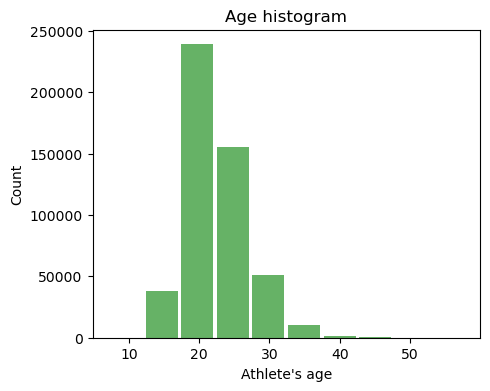

In [1015]:
#histogram with corrected data
plt.figure(figsize=(5,4))
plt.hist(df_all2['age'], alpha = 0.6, rwidth=0.9, color = 'green')
plt.xlabel("Athlete's age")
plt.ylabel('Count')
plt.title('Age histogram')

### wind analysis

In [995]:
df_all2['wind'].max()

16.6

In [996]:
df_all2['wind'].min()

-9.0

Text(0.5, 1.0, 'Wind histogram')

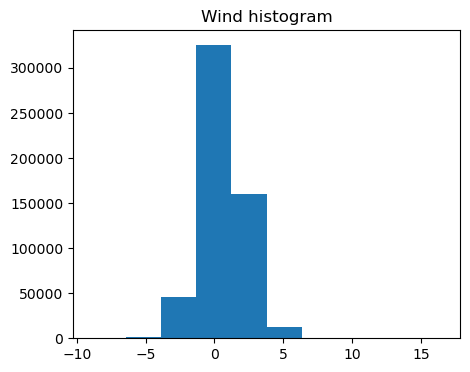

In [998]:
plt.figure(figsize=(5,4))
plt.hist(df_all2['wind'])
plt.title('Wind histogram')

In [1003]:
#looking for outliers
len(df_all2[df_all2['wind'] > 8])

93

In [1010]:
len(df_all2[df_all2['wind'] < -7])

43

In [1011]:
#all values above 8 change to 8, and below -7 change to -7
df_all2['wind'] = df_all2.apply(lambda row: -7 if row['wind'] < -7 else row['wind'], axis=1)
df_all2['wind'] = df_all2.apply(lambda row: 8 if row['wind'] > 8 else row['wind'], axis=1)

Text(0.5, 1.0, 'Wind histogram')

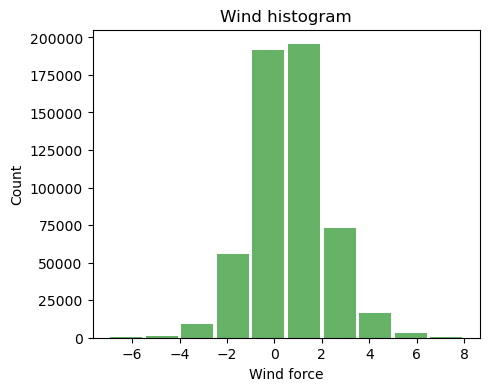

In [1014]:
#histogram with corrected data - outliers removed
plt.figure(figsize=(5,4))
plt.hist(df_all2['wind'], alpha = 0.6, rwidth=0.9, color = 'green')
plt.xlabel('Wind force')
plt.ylabel('Count')
plt.title('Wind histogram')

#### competition country analysis

In [1016]:
df_comp_country = df_all2[['country_competition', 'name']].groupby(by = 'country_competition', as_index = False).count()
df_comp_country = df_comp_country.rename(columns = {'name': 'count'})
df_comp_country = df_comp_country.sort_values('count', ascending = False).reset_index().drop(columns = 'index')
df_comp_country

,country_competition,count
0,United States,156650
1,Japan,38226
2,Germany,31633
3,France,29518
4,Great Britain & N.I.,29341
...,...,...
175,Norfolk Island,1
176,Aruba,1
177,Guam,1
178,Cambodia,1


Text(0, 0.5, 'Number of countries')

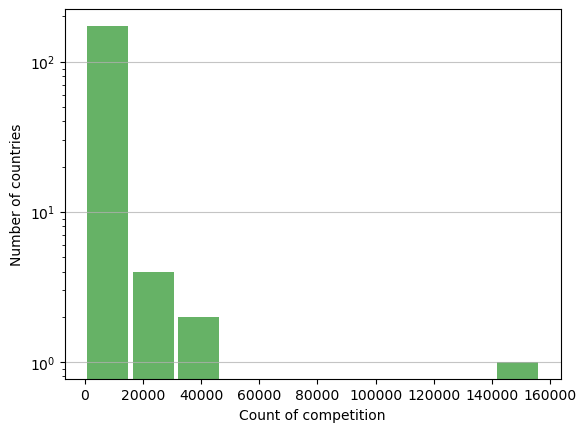

In [1018]:
df_comp_country['count'].plot(kind = 'hist', logy = True, color = 'green', alpha = 0.6, rwidth=0.9)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Count of competition')
plt.ylabel('Number of countries')

#### date competition analysis

In [1019]:
df_all2['year'].min()

1955.0

In [1020]:
df_all2['year'].max()

2022.0

Text(0.5, 1.0, 'Year')

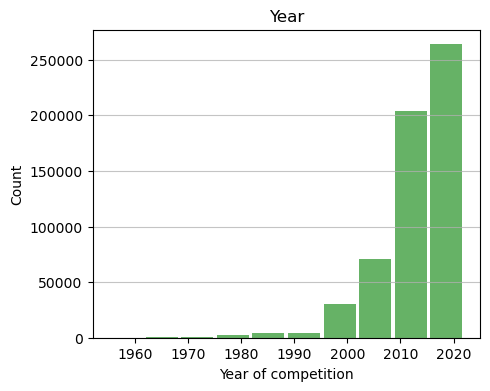

In [1042]:
plt.figure(figsize=(5,4))
plt.hist(df_all2['year'], alpha = 0.6, rwidth=0.9, color = 'green')
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Year of competition')
plt.ylabel('Count')
plt.title('Year')

In [1037]:
dozen = [int(repr(x)[-4]) if repr(x)[0] == '1' or repr(x)[0] == '2' else np.nan for x in df_all2['year']]
dozen2 = [x + 10 if x < 3 else x for x in dozen]

In [1040]:
pd.Series(dozen2).value_counts()

11.0    334481
12.0    114899
10.0    103650
9.0      19979
8.0       5695
7.0       2220
6.0        330
5.0         16
dtype: int64

Text(0.5, 1.0, 'Number of competition in decades')

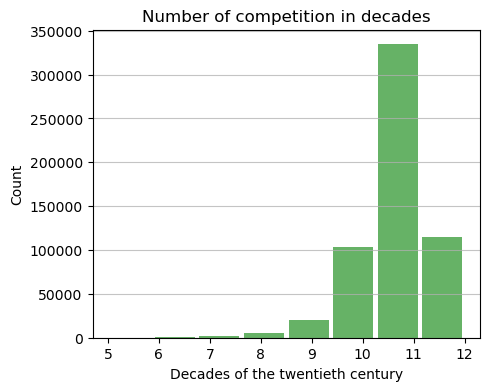

In [1043]:
plt.figure(figsize=(5,4))
plt.hist(dozen2, bins = 8, alpha = 0.6, rwidth=0.9, color = 'green')
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Decades of the twentieth century')
plt.ylabel('Count') 
plt.title('Number of competition in decades')

#### number of starts athlete in career

In [1052]:
df_number = df_all2[['number', 'name']].groupby(by = 'number', as_index = False).count()
df_number = df_number.rename(columns = {'name': 'count'})
df_number = df_number.sort_values('count', ascending = False).reset_index().drop(columns = 'index')
df_number

,number,count
0,14249856,384
1,14192940,379
2,14224942,358
3,14218403,318
4,14202005,300
...,...,...
33723,14755804,1
33724,14497650,1
33725,14246600,1
33726,14755440,1


In [1053]:
s.mean(df_number['count'])

17.234256404174573

In [1054]:
s.median(df_number['count'])

9.0

Text(0.5, 1.0, 'Number of starts per athlete in career')

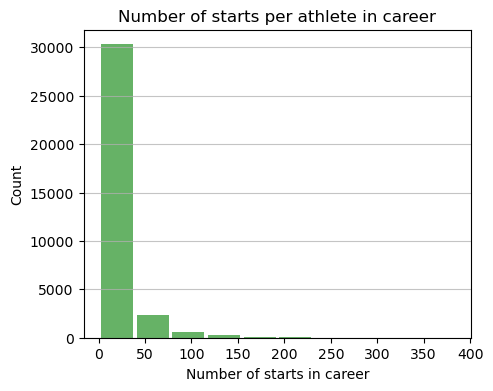

In [1075]:
plt.figure(figsize=(5,4))
plt.hist(df_number['count'], alpha = 0.6, rwidth=0.9, color = 'green')
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Number of starts in career')
plt.ylabel('Count') 
plt.title('Number of starts per athlete in career')

In [1066]:
len(df_number[df_number['count'] >= 10])

16746

#### number of starts athlete in season

In [1071]:
df_number_season = df_all2[['number', 'year', 'name']].groupby(by = ['number', 'year'], as_index = False).count()
df_number_season = df_number_season.rename(columns = {'name': 'count'})
df_number_season = df_number_season.sort_values('count', ascending = False).reset_index().drop(columns = 'index')
df_number_season

,number,year,count
0,14194924,2003.0,43
1,14366936,2011.0,42
2,14194924,1998.0,39
3,14214947,2002.0,39
4,14170229,2005.0,36
...,...,...,...
125551,14419203,2014.0,1
125552,14419203,2016.0,1
125553,14782330,2017.0,1
125554,14419214,2010.0,1


In [1073]:
s.mean(df_number_season['count'])

4.629567682946255

In [1074]:
s.median(df_number_season['count'])

3.0

Text(0.5, 1.0, 'Number of starts per athlete in season')

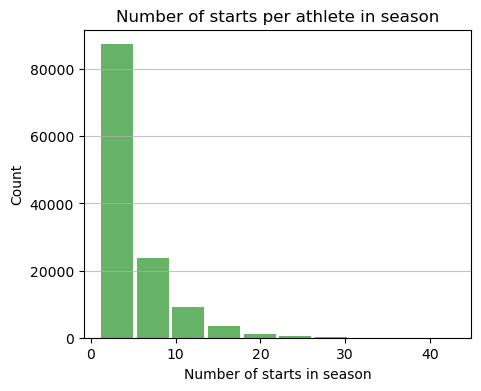

In [1076]:
plt.figure(figsize=(5,4))
plt.hist(df_number_season['count'], alpha = 0.6, rwidth=0.9, color = 'green')
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Number of starts in season')
plt.ylabel('Count') 
plt.title('Number of starts per athlete in season')

In [1077]:
len(df_number[df_number_season['count'] >= 10])

C:\Users\adasz\AppData\Local\Temp\ipykernel_10804\842193309.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  len(df_number[df_number_season['count'] >= 10])


14312

#### if_country analysis

In [1070]:
#in as many as 82% of starts, the competitor ran in his country
round((df_all2['if_country'].value_counts())/len(df_all2), 2)

1    0.82
0    0.18
Name: if_country, dtype: float64

# Conversion of categorical values into numbers

### country conversion

In [1112]:
country_list = list(set(list(df_all2['country']) + list(df_all2['country_competition'])))

In [1113]:
country_id = [country_list.index(x) for x in df_all2['country']]
country_comp_id = [country_list.index(x) for x in df_all2['country_competition']]

In [1132]:
df_all2['country_id'] = country_id
df_all2['country_comp_id'] = country_comp_id
df_all2

,name,country,abb_coun,number,birth_date,url_athlete,result,date_competition,abb_country_competition,city_competition,...,if_country,year,start_career,start_season,pb,sb,height,value,country_id,country_comp_id
0,Kaarel JÕEVÄLI,Estonia,est,14164603,1990-01-08,https://www.worldathletics.org/athletes/Estoni...,11.40,2009-07-23 00:00:00,srb,Novi Sad,...,0,2009.0,1,1,NaN,NaN,473.0,1,191,86
1,Kaarel JÕEVÄLI,Estonia,est,14164603,1990-01-08,https://www.worldathletics.org/athletes/Estoni...,11.09,2010-07-09 00:00:00,est,Kose,...,1,2010.0,2,1,11.40,NaN,61.0,1,191,191
2,Kaarel JÕEVÄLI,Estonia,est,14164603,1990-01-08,https://www.worldathletics.org/athletes/Estoni...,11.23,2010-07-16 00:00:00,est,Tallinn,...,1,2010.0,3,2,11.40,NaN,61.0,1,191,191
3,Kaarel JÕEVÄLI,Estonia,est,14164603,1990-01-08,https://www.worldathletics.org/athletes/Estoni...,11.21,2010-07-16 00:00:00,est,Tallinn,...,1,2010.0,4,3,11.40,NaN,61.0,1,191,191
4,Kaarel JÕEVÄLI,Estonia,est,14164603,1990-01-08,https://www.worldathletics.org/athletes/Estoni...,10.93,2011-06-04 00:00:00,fin,Seinäjoki,...,0,2011.0,5,1,11.21,NaN,164.0,1,191,73
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581272,Kotaro YAMAMOTO,Japan,jpn,15054047,2005-10-04,https://www.worldathletics.org/athletes/Japan/...,10.88,2022-11-03 00:00:00,jpn,Omuta,...,1,2022.0,1,1,NaN,NaN,438.0,1,117,117
581273,Kazuya IWATA,Japan,jpn,15054107,2005-06-25,https://www.worldathletics.org/athletes/Japan/...,10.71,2022-10-09 00:00:00,jpn,Yokohama,...,1,2022.0,1,1,NaN,NaN,438.0,1,117,117
581274,Kazuya IWATA,Japan,jpn,15054107,2005-06-25,https://www.worldathletics.org/athletes/Japan/...,10.79,2022-10-09 00:00:00,jpn,Yokohama,...,1,2022.0,2,2,10.71,10.71,438.0,1,117,117
581275,Subiarann MUGABI,Japan,jpn,15054126,2004-03-01,https://www.worldathletics.org/athletes/Japan/...,10.96,2022-10-15 00:00:00,jpn,Kanazawa,...,1,2022.0,1,1,NaN,NaN,438.0,1,117,117


### city conversion

In [1134]:
city_list = list(set(df_all2['city_competition']))

In [1137]:
city_comp_id = [city_list.index(x) for x in df_all2['city_competition']]

In [1148]:
df_all2['city_comp_id'] = city_comp_id
df_all2

,name,country,abb_coun,number,birth_date,url_athlete,result,date_competition,abb_country_competition,city_competition,...,year,start_career,start_season,pb,sb,height,value,country_id,country_comp_id,city_comp_id
0,Kaarel JÕEVÄLI,Estonia,est,14164603,1990-01-08,https://www.worldathletics.org/athletes/Estoni...,11.40,2009-07-23 00:00:00,srb,Novi Sad,...,2009.0,1,1,NaN,NaN,473.0,1,191,86,2233
1,Kaarel JÕEVÄLI,Estonia,est,14164603,1990-01-08,https://www.worldathletics.org/athletes/Estoni...,11.09,2010-07-09 00:00:00,est,Kose,...,2010.0,2,1,11.40,NaN,61.0,1,191,191,245
2,Kaarel JÕEVÄLI,Estonia,est,14164603,1990-01-08,https://www.worldathletics.org/athletes/Estoni...,11.23,2010-07-16 00:00:00,est,Tallinn,...,2010.0,3,2,11.40,NaN,61.0,1,191,191,2191
3,Kaarel JÕEVÄLI,Estonia,est,14164603,1990-01-08,https://www.worldathletics.org/athletes/Estoni...,11.21,2010-07-16 00:00:00,est,Tallinn,...,2010.0,4,3,11.40,NaN,61.0,1,191,191,2191
4,Kaarel JÕEVÄLI,Estonia,est,14164603,1990-01-08,https://www.worldathletics.org/athletes/Estoni...,10.93,2011-06-04 00:00:00,fin,Seinäjoki,...,2011.0,5,1,11.21,NaN,164.0,1,191,73,517
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581272,Kotaro YAMAMOTO,Japan,jpn,15054047,2005-10-04,https://www.worldathletics.org/athletes/Japan/...,10.88,2022-11-03 00:00:00,jpn,Omuta,...,2022.0,1,1,NaN,NaN,438.0,1,117,117,888
581273,Kazuya IWATA,Japan,jpn,15054107,2005-06-25,https://www.worldathletics.org/athletes/Japan/...,10.71,2022-10-09 00:00:00,jpn,Yokohama,...,2022.0,1,1,NaN,NaN,438.0,1,117,117,1245
581274,Kazuya IWATA,Japan,jpn,15054107,2005-06-25,https://www.worldathletics.org/athletes/Japan/...,10.79,2022-10-09 00:00:00,jpn,Yokohama,...,2022.0,2,2,10.71,10.71,438.0,1,117,117,1245
581275,Subiarann MUGABI,Japan,jpn,15054126,2004-03-01,https://www.worldathletics.org/athletes/Japan/...,10.96,2022-10-15 00:00:00,jpn,Kanazawa,...,2022.0,1,1,NaN,NaN,438.0,1,117,117,2060


# Selection of columns needed for training

In [1149]:
df_new = df_all2[['number', 'age', 'wind', 'year', 'start_career', 'start_season', 'pb', 'sb', 'height', 'country_id', 'country_comp_id', 'if_country', 'city_comp_id', 'result']]
df_new

,number,age,wind,year,start_career,start_season,pb,sb,height,country_id,country_comp_id,if_country,city_comp_id,result
0,14164603,19.55,-2.3,2009.0,1,1,NaN,NaN,473.0,191,86,0,2233,11.40
1,14164603,20.51,2.1,2010.0,2,1,11.40,NaN,61.0,191,191,1,245,11.09
2,14164603,20.53,2.4,2010.0,3,2,11.40,NaN,61.0,191,191,1,2191,11.23
3,14164603,20.53,-0.7,2010.0,4,3,11.40,NaN,61.0,191,191,1,2191,11.21
4,14164603,21.42,2.8,2011.0,5,1,11.21,NaN,164.0,191,73,0,517,10.93
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581272,15054047,17.09,1.5,2022.0,1,1,NaN,NaN,438.0,117,117,1,888,10.88
581273,15054107,17.30,1.8,2022.0,1,1,NaN,NaN,438.0,117,117,1,1245,10.71
581274,15054107,17.30,1.1,2022.0,2,2,10.71,10.71,438.0,117,117,1,1245,10.79
581275,15054126,18.64,0.4,2022.0,1,1,NaN,NaN,438.0,117,117,1,2060,10.96


# Collecting weather data

In [6]:

results=pd.read_csv('Data/df_all.csv',index_col=[0])

#Country names in URLs are shortened, so proper dictionary has to be implemented:
countrycodes=pd.read_csv('Data/countrycodes.csv')
display(countrycodes)
#Exclusively, in the US, the name of state also has to be included. In gathered data, some cities are labeled just by the name of state. 
#So, data was simplified to state capital
states=pd.read_csv('Data/states.csv')
display(states)

,Country,two_letters_code,three_letters_code,Unnamed: 3
0,Afghanistan,AF,AFG,NaN
1,Albania,AL,ALB,NaN
2,Algeria,DZ,DZA,NaN
3,American Samoa,AS,ASM,NaN
4,Andorra,AD,AND,NaN
...,...,...,...,...
243,Wallis and Futuna,WF,WLF,NaN
244,Western Sahara,EH,ESH,NaN
245,Yemen,YE,YEM,NaN
246,Zambia,ZM,ZMB,NaN


,FullName,ShortName,Capital
0,Alabama,AL,Montgomery
1,Alaska,AK,Juneau
2,Arizona,AZ,Phoenix
3,Arkansas,AR,Little Rock
4,California,CA,Sacramento
5,Colorado,CO,Denver
6,Connecticut,CT,Hartford
7,Delaware,DE,Dover
8,Florida,FL,Tallahassee
9,Georgia,GA,Atlanta


In [23]:
#Save places and dates to check-list in order to update the weeather database (NOT TO REPLACE)
placedate=results.date+'#'+results.City+'#'+results.country_short
placedate = list(dict.fromkeys(placedate))
len(placedate)

64320

## Future data normalization functions

In [24]:
def ConvertToCelsius(temp):
        return (temp-32)*(5/9)
    
    
def GetMostPopularCondition(conditions):
        return Counter(conditions).most_common(1)[0][0]

In [25]:
#The page loads ads at first seconds, the method below runs chromedriver and waits 5ms 
#for content to scrap 
# also, the delay does not weaken the site server
def render_page(url):
    driver = webdriver.Chrome('chromedriver')
    driver.get(url)
    time.sleep(5)
    r = driver.page_source
    driver.quit()
    return r

In [26]:
#get and process content from url
def scraper(url):
    r = render_page(url)
    print(url)
    soup = BeautifulSoup(r, "html.parser")
    container = soup.find('lib-city-history-observation')
    try:
        check = container.find('tbody')
        data = []
        for c in check.find_all('tr', class_='ng-star-inserted'):
            for i in c.find_all('td', class_='ng-star-inserted'):
                trial = i.text
                trial = trial.strip('  ')
                data.append(trial)
    except:
        return '','','','',''
    print(data)
    Temperature=[]
    Humidity=[]
    Pressure=[]
    Condition=[]
    if(len(data)>9):
        for i in range(0,len(data),10):
            #the data does not contain time of runs, so the result is a median value of 9AM-12PM timestamp
            if data[i][:1]=='9' or data[i][:2]=='10' or data[i][:2]=='11' or data[i][-2:]=='PM':
                print("The time is: "+data[i][:2]+data[i][-2:])
                Temperature.append(ConvertToCelsius(int(data[i+1][:-3])))
                Humidity.append(int(data[i+3][:-3]))
                Pressure.append((float(data[i+7][:-4])*1013)/29.92)#inch to atm
                Condition.append(data[i+9])
        if(len(Temperature)>0):
            return  str(round(med(Temperature),1)),  str(round(med(Humidity),1)),  str(round(med(Pressure),2)),GetMostPopularCondition(Condition)

    return  '','','','',''

In [34]:
#Creates weatherdatahistory dataframe
if path.exists('Data/WeatherDataHistory.csv')==False:		
    pd.DataFrame({'City':[],'Date':[],'Temperature':[],'Humidity':[],'Pressure':[],'Condition':[]}).to_csv('Data/WeatherDataHistory.csv')



In [36]:

    
for i in range(len(placedate)):
    x=placedate[i].split('#') #data,miasto,kraj
    weatherdata=pd.read_csv('Data/WeatherDataHistory.csv',index_col=[0])
    if ((weatherdata['City'] == x[1]) & (weatherdata['Date'] == x[0])).any()==False:
        print("Current data: "+x[1]+"&"+x[0])
        print("CountryCodeNeeded: "+x[2])
        for j in range(len(countrycodes)):
            if x[2]==countrycodes.iloc[j].three_letters_code:
                print("CountryCodeGot: "+str(countrycodes.iloc[j].two_letters_code))
                if str(countrycodes.iloc[j].two_letters_code)=='US':
                    for k in range(len(states)):
                        if x[1]==states.iloc[k].Capital:
                            page = 'https://www.wunderground.com/history/daily/'+str(countrycodes.iloc[j].two_letters_code)+'/'+states.iloc[k].ShortName+'/'+x[1]+'/date/'+x[0]
                            Temperature,  Humidity,  Pressure, Condition=scraper(page)
                            weatherdata = pd.concat([pd.DataFrame([[x[1],x[0],Temperature,  Humidity,  Pressure, Condition]], columns=weatherdata.columns), weatherdata], ignore_index=True)
                            weatherdata.to_csv('Data/WeatherDataHistory.csv')
                            break
                else:
                    code=str(countrycodes.iloc[j].two_letters_code)
                    if str(countrycodes.iloc[j].two_letters_code)=='NaN':
                        code='NA'
                    page = 'https://www.wunderground.com/history/daily/'+code+'/'+x[1]+'/date/'+x[0]
                    Temperature,  Humidity,  Pressure, Condition=scraper(page)
                    weatherdata = pd.concat([pd.DataFrame([[x[1],x[0],Temperature,  Humidity,  Pressure, Condition]], columns=weatherdata.columns), weatherdata], ignore_index=True)
                    weatherdata.to_csv('Data/WeatherDataHistory.csv')
                break
    clear_output()

Current data: London&2017-08-04
CountryCodeNeeded: GBR
CountryCodeGot: GB


KeyboardInterrupt: 

DATA VISUALIZATION AND PREPROCESSING

In [3]:
weatherdata=pd.read_csv('Data/WeatherDataHistory.csv',index_col=[0])
weatherdata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   City         2 non-null      object 
 1   Date         2 non-null      object 
 2   Temperature  2 non-null      float64
 3   Humidity     2 non-null      float64
 4   Pressure     2 non-null      float64
 5   Condition    2 non-null      object 
dtypes: float64(3), object(3)
memory usage: 112.0+ bytes


In [4]:
weatherdata.Condition.unique()

array(['Fair', 'Fair / Windy'], dtype=object)

As seen above, data has a lot of values which need to be normalized. The data will be categorized as followed:

Fair --> 5
Partly Cloudy --> 4
Mostly CLoudy --> 3
Cloudy/Rain cats n' dogs etc./fog patches --> 2
Fog/Smoke --> 1

In [5]:
weatherdata.Condition = weatherdata.Condition.replace(['Fair','Fair / Windy'], '5')
weatherdata.Condition = weatherdata.Condition.replace(['Partly Cloudy' , 'Partly Cloudy / Windy'], '4')
weatherdata.Condition = weatherdata.Condition.replace(['Mostly Cloudy' , 'Mostly Cloudy / Windy'], '3')
weatherdata.Condition = weatherdata.Condition.replace(['Cloudy' , 'Cloudy / Windy' , 'Haze' , 'Rain Shower' , 'Showers in the Vicinity' , 'Light Rain Shower / Windy' , 'Rain Shower' , 'Light Rain' , 'Light Rain / Windy' ,'Light Rain Shower' , 'T-Storm' , 'Thunder' ,'Light Drizzle', 'Rain' ,'Light Rain with Thunder' , 'Light Snow', 'Light Drizzle / Windy', 'Heavy T-Storm', 'Thunder in the Vicinity', 'T-Storm / Windy', 'Drizzle', 'Heavy Rain Shower', 'Patches of Fog'], '2')
weatherdata.Condition = weatherdata.Condition.replace(['Blowing Dust / Windy', 'Mist' , 'Fog' , 'Smoke', 'Sand', 'Blowing Sand','Blowing Sand / Windy'], '1')

In [6]:
#At this stage, the rain value is evaluated. Every condition including storm or light rain will be from now on tolerated as wet surface:
rain =[]
vals=['Rain Shower' , 'Showers in the Vicinity' , 'Light Rain Shower / Windy' , 'Rain Shower' , 'Light Rain' , 'Light Rain / Windy' ,'Light Rain Shower' , 'T-Storm' , 'Thunder' ,'Light Drizzle', 'Rain' ,'Light Rain with Thunder' , 'Light Snow', 'Light Drizzle / Windy', 'Heavy T-Storm', 'Thunder in the Vicinity', 'T-Storm / Windy', 'Drizzle', 'Heavy Rain Shower']
for item in weatherdata.Condition:
    if type(item)==float:
        rain.append(None)
    elif item in vals:
        rain.append("1")
    else:
        rain.append("0")
weatherdata.Condition = weatherdata.Condition.replace(['Fair','Fair / Windy'], '5')
weatherdata['Rain']=rain


Minimalization of columns with high numbers to values between 0 and 1

In [7]:
for item in weatherdata.Pressure:
    weatherdata.Pressure = weatherdata.Pressure.replace(item, item/weatherdata['Pressure'].max())

for item in weatherdata.Humidity:
    weatherdata.Humidity = weatherdata.Humidity.replace(item, item/100)
    
for item in weatherdata.Temperature:
    weatherdata.Temperature = weatherdata.Temperature.replace(item, (item - weatherdata['Temperature'].min())/(weatherdata['Temperature'].max()-weatherdata['Temperature'].min()))


#Some wind results have characters instead of integers suggesting wind direction. The next step replaces them:
for item in results.wiatr:
    if item=='NWI' or item=='w':
        results.wiatr=results.wiatr.replace(item, None)
        
min=results['wiatr'].min()
max=results['wiatr'].max()

for item in results.wiatr:
    try:
        results.wiatr = results.wiatr.replace(item, ((float(item)) - min)/(max-min))
    except:
        results.wiatr=np.NaN

C:\Users\marci\AppData\Local\Temp\ipykernel_33428\1208450446.py:8: RuntimeWarning: invalid value encountered in double_scalars
  weatherdata.Temperature = weatherdata.Temperature.replace(item, (item - weatherdata['Temperature'].min())/(weatherdata['Temperature'].max()-weatherdata['Temperature'].min()))


NameError: name 'results' is not defined

Visualization

In [ ]:
weatherdata.describe()

In [ ]:
weatherdata.isnull().sum()

In [ ]:
sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 5]})
sns.distplot(
    weatherdata['Temperature'], norm_hist=False, kde=False, bins=20, hist_kws={"alpha": 1}
).set(xlabel='Temperature', ylabel='counts')

In [ ]:
sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 5]})
sns.distplot(
    weatherdata['Humidity'], norm_hist=False, kde=False, bins=20, hist_kws={"alpha": 1}
).set(xlabel='Humidity', ylabel='counts')

In [ ]:
sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 5]})
sns.distplot(
    weatherdata['Pressure'], norm_hist=False, kde=False, bins=20, hist_kws={"alpha": 1}
).set(xlabel='Pressure', ylabel='counts');

In [ ]:
ax=sns.heatmap(weatherdata.isnull(), yticklabels=False, cbar=False)

In [ ]:
sorted_nb = weatherdata.groupby(['Humidity'])['Temperature'].median().sort_values()
sns.boxplot(x=weatherdata['Humidity'], y=weatherdata['Temperature'], order=list(sorted_nb.index))

In [ ]:
sns.scatterplot(x=weatherdata['Humidity'], y=weatherdata['Temperature']);

In [ ]:
#read previously gathered weatherdata from the file
weatherdata=pd.read_csv('Data/WeatherDataProcessed.csv',index_col=[0])

#merge weather data with main dataframe 
resulttolearn=results.merge(weatherdata[['City','Date','Temperature','Humidity','Pressure','Condition','Rain']],how='left', on=['Date','City'])

#City to ints

skr = list(resulttolearn['City'].unique())
skr_uniq = []
for x in skr:
    if x not in skr_uniq:
        skr_uniq.append(x)
skr_sort = sorted(zip(skr_uniq))
skr_slownik = {}
for i, s in enumerate(skr_sort):
    skr_slownik[s[0]] = i
kraj_zawodow = []
for k in resulttolearn['City']:
    kraj_zawodow.append(skr_slownik[k])
resulttolearn['City'] = kraj_zawodow

#Remove data for visualization
df=resulttolearn.drop(['Unnamed: 0','nazwa', 'kraj','data_urodz','skrot_kr','Date','kraj_skrot'], axis=1)

In [ ]:
#Read prepared data and shuffle
results=pd.read_csv('Data/results.csv', index_col=0).sample(frac = 1)
results

In [ ]:
#Removing outliers
results = results[results.result < 12]


# Method #1 Trimming NaN values

In [ ]:
kol_nan = []
for k in results.columns:
    if results.describe()[k]['count'] < len(results):
        print(k, results.describe()[k]['count'])
        kol_nan.append(k)

In [ ]:
results1 = copy.deepcopy(results)
for k in kol_nan:
    results1 = results1[results1[k].isna()==False]
results1

In [ ]:
#separating 30% data to train and the remaining part to test
d3 = int(len(results1) * 0.3)

results_train1 = results1[:d3]
results_test1 = results1[d3:]
result_train1 = results_train1['result']
result_test1 = results_test1['result']
results_train1 = results_train1.drop(['result'], axis = 1)
results_test1 = results_test1.drop(['result'], axis = 1)

# Method #2 Replacing NaN values with mean

In [ ]:
results2 = copy.deepcopy(results)

for i, k in enumerate(kol_nan):
    if i < len(kol_nan)-2:    #mean value
        m = results2[k].mean()
    else:                   #the most common value
        m= float(results2[k].mode())
    results2[k].fillna(value=m, inplace=True)

#separating 30% data to train and the remaining part to test
d32 = int(len(results2) * 0.3)
results_train2 = results2[:d32]
results_test2 = results2[d32:]
result_train2 = results_train2['result']
result_test2 = results_test2['result']
results_train2 = results_train2.drop(['result'], axis = 1)
results_test2 = results_test2.drop(['result'], axis = 1)

# Choosing the best factors (Lasso Method)

In [ ]:
#lasso
def soft_threshold(r, rho, lamda):
    if rho < - lamda:   #comparison of rho with lamda parameter
        return (rho + lamda)
    elif rho >  lamda:
        return (rho - lamda)
    else: 
        return 0

def coordinate_descent_lasso(X, Y, num_iters, lamda):
    m, n = X.shape   #shape X
    for i in range(num_iters):
        lista = []
        for j in range(n):
            blad = Y - np.dot(X, np.ones(n))  #the magnitude of error
            r = np.sum(np.power(X[X.columns[j]], 2))            
            rho = np.sum(np.dot((blad + np.array(X[X.columns[j]])), X[X.columns[j]]))
            lista.append(soft_threshold(r, rho, lamda))
        
    dobre_cechy = []
    for s, k in enumerate(lista):
        if k != 0:   #good columns are only these, where real_val is > 0, 
                       #thus, fullfilled the condition: rho >  lamda or rho < - lamda
            dobre_cechy.append(X.columns[s])
    return dobre_cechy

#cechy_lasso = coordinate_descent_lasso(results_train2, result_train2, 20, 8e13)
cechy_lasso = coordinate_descent_lasso(results_train2, result_train2, 20, 1e12)   #5 most reliable factors, all NaN = mean
print('cechy lasso:', cechy_lasso)

In [ ]:
set(list(results_train1.columns)) - set(cechy_lasso)   #the least reliable data - trimmed NaN

In [ ]:
cechy_lasso   #5 most reliable factors - trimmed NaN

In [ ]:
set(list(results_train1.columns)) - set(cechy_lasso)   #the least reliable data, NaN = mean

In [ ]:
cechy_lasso   #5 most reliable factors, NaN = mean

# Learning

## 4-layers model - trimmed NaN

In [ ]:
x = torch.tensor(results_train1.values, dtype=torch.float)
x_test=torch.tensor(results_test1.values, dtype=torch.float)
y = torch.tensor(result_train1.values, dtype=torch.float)
y_test=torch.tensor(result_test1.values, dtype=torch.float)

In [ ]:
model = nn.Sequential(
        nn.Linear(17, 20),
        nn.ReLU(),
        nn.Linear(20,100),
        nn.Sigmoid(),
        nn.Linear(100,1)
    )
model.to()

In [ ]:
criterion = torch.nn.MSELoss() 
optimizer = optim.SGD(model.parameters(), lr = 0.00975)   #lr - learning rate

In [ ]:
epochs=50
losses=[]
for epoch in range(epochs):
    totalLoss = 0
    pred_real_val = []
    for i in range(len(x)):
        ypred = model(x[i])
        y_pred_test=model(x_test[i])
        pred_real_val.append(y_pred_test)
        loss = criterion(ypred, y[i])
        totalLoss+=loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    losses.append(totalLoss)
    print('Total training loss: ', totalLoss)
    with torch.no_grad():
        loss2 = criterion(y_pred_test, y_test[len(x)])
        print(f'Loss test: {loss2:.8f}')
    ##if epoch%50==0 or epoch==0:
        ##print('Total loss: ', totalLoss)

plt.plot(range(epochs), losses)#shows plot of the presented system
plt.ylabel('Cross Entropy Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
#Mean, Min, Max, SSE, MSE, RMSE and R SQUARED
#sprawdzenie ile predictedcji jest mniejszych od danego bledu
good = 0
real_val = []
predicted = []
suma = 0
for i in range(len(y)):
    real_val.append(y_test[i].item())
    predicted.append(pred_real_val[i].item())
    suma += abs(y[i].item() - pred_real_val[i].item())
    if abs(y[i].item() - pred_real_val[i].item()) < 0.2:
        good += 1
print(good/len(y))

print('mean error:', suma/len(y)) #Mean Absolute Error
#<0.15 = 0.54 (z real_valosciami odstajacymi) 0.48623579221053004, 0.48876552535881806
#obliczanie błędu SSE - suma kwadratów błędu estymacji, błąd średniokwadratowy i RMSE
e = np.array(real_val) - np.array(predicted)
sse = np.sum(np.power(e, 2))
print('SSE:', sse)
mse = np.mean(np.power(e, 2))
print('MSE:', mse)
rmse = np.sqrt(np.mean(np.power(e, 2)))
print('RMSE:', rmse)

print('Max testing value:: ',max(real_val))
print('Min testing value: ',min(real_val))
print('Max value predicted: ',max(predicted))
print('Min value predicted: ',min(predicted))

model=LinearRegression()
model.fit(x,y)
r_sq=model.score(x,y)
print(r_sq)
pd.qcut(predicted,q=17,precision=0)

In [ ]:
plt.plot(real_val, label='Real values')
plt.plot(predicted, label = 'Predicted results')
plt.xlabel('score number')
plt.ylabel('time [s]')
plt.legend(loc='upper right')

## 5-layers model - trimmed NaN

In [ ]:
model = nn.Sequential(
        nn.Linear(17, 64),
        nn.ReLU(),
        nn.Linear(64,128),
        nn.ReLU(),
        nn.Linear(128,256),
        nn.Sigmoid(),
        nn.Linear(256,1)
    )
model.to()
criterion = torch.nn.MSELoss()  #zmienic kryterium
optimizer = optim.SGD(model.parameters(), lr = 0.000975)#, momentum = 0.9)   #lr - learning rate

In [ ]:

losses2=[]
for epoch in range(epochs):
    totalLoss = 0
    pred_real_val = []
    for i in range(len(x)):
        ypred = model(x[i])
        y_pred_test=model(x_test[i])
        pred_real_val.append(y_pred_test)
        loss = criterion(ypred, y[i])
        totalLoss+=loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    losses2.append(totalLoss)
    print('Total training loss: ', totalLoss)
    with torch.no_grad():
        loss2 = criterion(y_pred_test, y_test[len(x)])
        print(f'Loss test: {loss2:.8f}')
    ##if epoch%50==0 or epoch==0:
        ##print('Total loss: ', totalLoss)

plt.plot(range(epochs), losses, label='4 layers model')
plt.plot(range(epochs), losses2, label='5 layers model')#shows plot of the presented system
plt.legend()
plt.ylabel('Cross Entropy Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
#sprawdzenie ile predictedcji jest mniejszych od danego bledu
good = 0
real_val = []
predicted2 = []
suma = 0
for i in range(len(y)):
    real_val.append(y_test[i].item())
    predicted2.append(pred_real_val[i].item())
    suma += abs(y[i].item() - pred_real_val[i].item())
    if abs(y[i].item() - pred_real_val[i].item()) < 0.2:
        good += 1
print(good/len(y))

print('mean error', suma/len(y)) #Mean Absolute Error
#<0.15 = 0.54 (z real_valosciami odstajacymi) 0.48623579221053004, 0.48876552535881806
#obliczanie błędu SSE - suma kwadratów błędu estymacji, błąd średniokwadratowy i RMSE
e = np.array(real_val) - np.array(predicted2)
sse = np.sum(np.power(e, 2))
print('SSE:', sse)
mse = np.mean(np.power(e, 2))
print('MSE:', mse)
rmse = np.sqrt(np.mean(np.power(e, 2)))
print('RMSE:', rmse)

print('Max testing value:: ',max(real_val))
print('Min testing value: ',min(real_val))
print('Max value predicted: ',max(predicted2))
print('Min value predicted: ',min(predicted2))

model=LinearRegression()
model.fit(x,y)
r_sq=model.score(x,y)
print(r_sq)
pd.qcut(predicted2,q=17,precision=0)

In [ ]:
plt.plot(real_val, label='Real values')
plt.plot(predicted2, label = 'Predicted results (8 layers)')
plt.xlabel('score number')
plt.ylabel('time [s]')
plt.legend(loc='upper right')

## 6-layers model - trimmed NaN

In [ ]:
model = nn.Sequential(
        nn.Linear(17, 64),
        nn.ReLU(),
        nn.Linear(64,128),
        nn.ReLU(),
        nn.Linear(128,256),
        nn.ReLU(),
        nn.Linear(256,512),
        nn.Sigmoid(),
        nn.Linear(512,1)
    )
model.to()
criterion = torch.nn.MSELoss()  
optimizer = optim.SGD(model.parameters(), lr = 0.000975) #lr - learning rate

In [ ]:

losses3=[]
for epoch in range(epochs):
    totalLoss = 0
    pred_real_val = []
    for i in range(len(x)):
        ypred = model(x[i])
        y_pred_test=model(x_test[i])
        pred_real_val.append(y_pred_test)
        loss = criterion(ypred, y[i])
        totalLoss+=loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    losses3.append(totalLoss)
    print('Total training loss: ', totalLoss)
    with torch.no_grad():
        loss2 = criterion(y_pred_test, y_test[len(x)])
        print(f'Loss test: {loss2:.8f}')
    ##if epoch%50==0 or epoch==0:
        ##print('Total loss: ', totalLoss)

plt.plot(range(epochs), losses, label='4 layers model')
plt.plot(range(epochs), losses2, label='5 layers model')#shows plot of the presented system
plt.plot(range(epochs), losses3, label='6 layers model')#shows plot of the presented system
plt.legend()
plt.ylabel('Cross Entropy Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
#sprawdzenie ile predictedcji jest mniejszych od danego bledu
good = 0
real_val = []
predicted3 = []
suma = 0
for i in range(len(y)):
    real_val.append(y_test[i].item())
    predicted3.append(pred_real_val[i].item())
    suma += abs(y[i].item() - pred_real_val[i].item())
    if abs(y[i].item() - pred_real_val[i].item()) < 0.2:
        good += 1
print(good/len(y))

print('mean error', suma/len(y)) #Mean Absolute Error
#<0.15 = 0.54 (z real_valosciami odstajacymi) 0.48623579221053004, 0.48876552535881806
#obliczanie błędu SSE - suma kwadratów błędu estymacji, błąd średniokwadratowy i RMSE
e = np.array(real_val) - np.array(predicted3)
sse = np.sum(np.power(e, 2))
print('SSE:', sse)
mse = np.mean(np.power(e, 2))
print('MSE:', mse)
rmse = np.sqrt(np.mean(np.power(e, 2)))
print('RMSE:', rmse)

print('Max testing value:: ',max(real_val))
print('Min testing value: ',min(real_val))
print('Max value predicted: ',max(predicted3))
print('Min value predicted: ',min(predicted3))

model=LinearRegression()
model.fit(x,y)
r_sq=model.score(x,y)
print(r_sq)
pd.qcut(predicted3,q=17,precision=0)

In [ ]:
plt.plot(real_val, label='Real values')
plt.plot(predicted3, label = 'Predicted results (10 layers)')

plt.xlabel('score number')
plt.ylabel('time [s]')
plt.legend(loc='upper right')

## 3-layers model - NaN=mean

In [ ]:
x = torch.tensor(results_train2.values, dtype=torch.float)
x_test=torch.tensor(results_test2.values, dtype=torch.float)
y = torch.tensor(result_train2.values, dtype=torch.float)
y_test=torch.tensor(result_test2.values, dtype=torch.float)

In [ ]:
model = nn.Sequential(
        nn.Linear(17, 20),
        nn.ReLU(),
        nn.Linear(20,100),
        nn.Sigmoid(),
        nn.Linear(100,1)
    )
model.to()
criterion = torch.nn.MSELoss()  #zmienic kryterium
optimizer = optim.SGD(model.parameters(), lr = 0.000975)#, momentum = 0.9)   #lr - learning rate

In [ ]:

losses2=[]
for epoch in range(epochs):
    totalLoss = 0
    pred_real_val = []
    for i in range(len(x)):
        ypred = model(x[i])
        y_pred_test=model(x_test[i])
        pred_real_val.append(y_pred_test)
        loss = criterion(ypred, y[i])
        totalLoss+=loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    losses2.append(totalLoss)
    print('Total training loss: ', totalLoss)
    with torch.no_grad():
        loss2 = criterion(y_pred_test, y_test[len(x)])
        print(f'Loss test: {loss2:.8f}')
    ##if epoch%50==0 or epoch==0:
        ##print('Total loss: ', totalLoss)

plt.plot(range(epochs), losses, label='Removed nulls')
plt.plot(range(epochs), losses2, label='Nulls swapped to mean')#shows plot of the presented system
plt.legend()
plt.ylabel('Cross Entropy Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
#sprawdzenie ile predictedcji jest mniejszych od danego bledu
good = 0
real_val = []
predicted3 = []
suma = 0
for i in range(len(y)):
    real_val.append(y_test[i].item())
    predicted3.append(pred_real_val[i].item())
    suma += abs(y[i].item() - pred_real_val[i].item())
    if abs(y[i].item() - pred_real_val[i].item()) < 0.2:
        good += 1
print(good/len(y))

print('mean error', suma/len(y)) #Mean Absolute Error
#<0.15 = 0.54 (z real_valosciami odstajacymi) 0.48623579221053004, 0.48876552535881806
#obliczanie błędu SSE - suma kwadratów błędu estymacji, błąd średniokwadratowy i RMSE
e = np.array(real_val) - np.array(predicted3)
sse = np.sum(np.power(e, 2))
print('SSE:', sse)
mse = np.mean(np.power(e, 2))
print('MSE:', mse)
rmse = np.sqrt(np.mean(np.power(e, 2)))
print('RMSE:', rmse)

print('Max testing value:: ',max(real_val))
print('Min testing value: ',min(real_val))
print('Max value predicted: ',max(predicted3))
print('Min value predicted: ',min(predicted3))

model=LinearRegression()
model.fit(x,y)
r_sq=model.score(x,y)
print(r_sq)
pd.qcut(predicted3,q=17,precision=0)

In [ ]:
plt.plot(real_val, label='Real values')
plt.plot(predicted3, label = 'Predicted results')

plt.xlabel('score number')
plt.ylabel('time [s]')
plt.legend(loc='upper right')